In [1]:
import torch
import torch.utils
import torch.utils.data
from torch.utils.data import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import numpy as np


import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generative Adversarial Networks

In [2]:
import torchvision
import torchvision.transforms as transforms



batch_size = 256


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])    
])




# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transform)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [3]:
def show_batch(batch,nrow=32):
    im = torchvision.utils.make_grid(batch,nrow)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    plt.axis('off')

In [4]:
class Generator(nn.Module):
    def __init__(self, g_dims):
        super(Generator, self).__init__()       

        self.g_dims = g_dims

        self.g_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.g_dims[:-1], self.g_dims[1:])])
    
    # forward method
    def forward(self, x): 
        h = x
        for i, layer in enumerate(self.g_layers):
            h = layer(h)
            if i != len(self.g_layers) - 1:
                h = F.leaky_relu(h, 0.2)
            else:
                h = torch.tanh(h)
        
        return h
    
class Discriminator(nn.Module):
    def __init__(self, d_dims):
        super(Discriminator, self).__init__()

        # Last dimension of D network is for output
        self.d_dims = d_dims + [1]
        self.d_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.d_dims[:-1], self.d_dims[1:])])
        
    
    # forward method
    def forward(self, x):
        h = x
        for i, layer in enumerate(self.d_layers):
            h = layer(h)
            if i != len(self.d_layers) - 1:
                h = F.leaky_relu(h, 0.2)
                h = F.dropout(h, 0.3)
            else:
                h = torch.sigmoid(h)
        
        return h

In [5]:

# build network
z_dim = 64
mnist_dim = 784

g_dims=[64,256,512,1024,784]
d_dims=[784,1024,512,256]

G = Generator(g_dims).to(device)
D = Discriminator(d_dims).to(device)

In [6]:
G

Generator(
  (g_layers): ModuleList(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): Linear(in_features=1024, out_features=784, bias=True)
  )
)

In [7]:
D

Discriminator(
  (d_layers): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [8]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [9]:
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)


num_epochs = 2000

In [10]:
def D_train(x_real):
    D.zero_grad()
    
    bs = x_real.size(0)

    # train discriminator on real
    y_real = torch.ones(bs, 1).to(device)

    D_output = D(x_real)
        
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss, D_real_score, D_fake_score

In [11]:
def G_train(x):
    G.zero_grad()
    
    bs = x.size(0)

    z = torch.randn(bs, z_dim).to(device)
    y = torch.ones(bs, 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss

In [12]:
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)
real_scores = np.zeros(num_epochs)
fake_scores = np.zeros(num_epochs)

step = 100

# Start training
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.view(-1, mnist_dim).to(device)

        #                      Train the discriminator                       #
        d_loss, real_score, fake_score = D_train(images)

        #                        Train the generator                         #
        g_loss = G_train(images)
        
        #                          Update Statistics                          #
        d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.item()*(1./(i+1.))
        g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.item()*(1./(i+1.))
        real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().item()*(1./(i+1.))
        fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().item()*(1./(i+1.))
        
        if (i+1) % step == 0:
            print('Epoch [{:>3}/{}] | Step [{:>3}/{}]| d_loss: {:.4f} | g_loss: {:.4f} | D(x): {:.2f} | D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))

    print('----------------------------------------------------')
    print('|Epoch [{:>3}/{}] | d_loss: {:.4f} | g_loss: {:.4f} |'
          .format(epoch, num_epochs,d_losses[epoch], g_losses[epoch]))
    print('----------------------------------------------------')
    

# Save the model checkpoints 
torch.save(G.state_dict(), 'data/gan/G.ckpt')
torch.save(D.state_dict(), 'data/gan/D.ckpt')

Epoch [  0/2000] | Step [100/235]| d_loss: 1.8259 | g_loss: 0.4507 | D(x): 0.60 | D(G(z)): 0.69
Epoch [  0/2000] | Step [200/235]| d_loss: 0.5171 | g_loss: 3.3258 | D(x): 0.81 | D(G(z)): 0.23
----------------------------------------------------
|Epoch [  0/2000] | d_loss: 1.1387 | g_loss: 1.8867 |
----------------------------------------------------
Epoch [  1/2000] | Step [100/235]| d_loss: 0.1073 | g_loss: 7.8500 | D(x): 0.96 | D(G(z)): 0.05
Epoch [  1/2000] | Step [200/235]| d_loss: 0.1243 | g_loss: 5.9110 | D(x): 0.95 | D(G(z)): 0.06
----------------------------------------------------
|Epoch [  1/2000] | d_loss: 0.5077 | g_loss: 5.3247 |
----------------------------------------------------
Epoch [  2/2000] | Step [100/235]| d_loss: 0.1918 | g_loss: 8.5233 | D(x): 0.93 | D(G(z)): 0.07
Epoch [  2/2000] | Step [200/235]| d_loss: 0.2163 | g_loss: 7.6274 | D(x): 0.90 | D(G(z)): 0.05
----------------------------------------------------
|Epoch [  2/2000] | d_loss: 0.3747 | g_loss: 7.3222

----------------------------------------------------
|Epoch [ 23/2000] | d_loss: 0.4709 | g_loss: 3.0399 |
----------------------------------------------------
Epoch [ 24/2000] | Step [100/235]| d_loss: 0.3026 | g_loss: 4.0677 | D(x): 0.91 | D(G(z)): 0.10
Epoch [ 24/2000] | Step [200/235]| d_loss: 0.5401 | g_loss: 2.8315 | D(x): 0.82 | D(G(z)): 0.14
----------------------------------------------------
|Epoch [ 24/2000] | d_loss: 0.5057 | g_loss: 2.9516 |
----------------------------------------------------
Epoch [ 25/2000] | Step [100/235]| d_loss: 0.3684 | g_loss: 3.2631 | D(x): 0.86 | D(G(z)): 0.10
Epoch [ 25/2000] | Step [200/235]| d_loss: 0.5498 | g_loss: 2.1524 | D(x): 0.81 | D(G(z)): 0.20
----------------------------------------------------
|Epoch [ 25/2000] | d_loss: 0.5754 | g_loss: 2.7771 |
----------------------------------------------------
Epoch [ 26/2000] | Step [100/235]| d_loss: 0.4381 | g_loss: 2.3937 | D(x): 0.87 | D(G(z)): 0.18
Epoch [ 26/2000] | Step [200/235]| d_los

Epoch [ 47/2000] | Step [100/235]| d_loss: 0.7661 | g_loss: 1.8324 | D(x): 0.76 | D(G(z)): 0.27
Epoch [ 47/2000] | Step [200/235]| d_loss: 0.7169 | g_loss: 2.1849 | D(x): 0.76 | D(G(z)): 0.20
----------------------------------------------------
|Epoch [ 47/2000] | d_loss: 0.7970 | g_loss: 1.9731 |
----------------------------------------------------
Epoch [ 48/2000] | Step [100/235]| d_loss: 0.6552 | g_loss: 2.1028 | D(x): 0.77 | D(G(z)): 0.20
Epoch [ 48/2000] | Step [200/235]| d_loss: 0.7695 | g_loss: 1.8752 | D(x): 0.76 | D(G(z)): 0.27
----------------------------------------------------
|Epoch [ 48/2000] | d_loss: 0.7464 | g_loss: 2.0363 |
----------------------------------------------------
Epoch [ 49/2000] | Step [100/235]| d_loss: 0.6658 | g_loss: 2.1284 | D(x): 0.79 | D(G(z)): 0.23
Epoch [ 49/2000] | Step [200/235]| d_loss: 0.8198 | g_loss: 2.1752 | D(x): 0.75 | D(G(z)): 0.27
----------------------------------------------------
|Epoch [ 49/2000] | d_loss: 0.7521 | g_loss: 2.0425

----------------------------------------------------
|Epoch [ 70/2000] | d_loss: 0.9252 | g_loss: 1.5977 |
----------------------------------------------------
Epoch [ 71/2000] | Step [100/235]| d_loss: 0.8707 | g_loss: 1.7684 | D(x): 0.70 | D(G(z)): 0.27
Epoch [ 71/2000] | Step [200/235]| d_loss: 1.0250 | g_loss: 1.4234 | D(x): 0.66 | D(G(z)): 0.34
----------------------------------------------------
|Epoch [ 71/2000] | d_loss: 0.9307 | g_loss: 1.5712 |
----------------------------------------------------
Epoch [ 72/2000] | Step [100/235]| d_loss: 0.9922 | g_loss: 1.6812 | D(x): 0.69 | D(G(z)): 0.35
Epoch [ 72/2000] | Step [200/235]| d_loss: 0.9683 | g_loss: 1.5415 | D(x): 0.65 | D(G(z)): 0.29
----------------------------------------------------
|Epoch [ 72/2000] | d_loss: 0.9428 | g_loss: 1.5687 |
----------------------------------------------------
Epoch [ 73/2000] | Step [100/235]| d_loss: 0.9220 | g_loss: 1.7127 | D(x): 0.71 | D(G(z)): 0.30
Epoch [ 73/2000] | Step [200/235]| d_los

Epoch [ 94/2000] | Step [100/235]| d_loss: 1.1044 | g_loss: 1.3377 | D(x): 0.69 | D(G(z)): 0.39
Epoch [ 94/2000] | Step [200/235]| d_loss: 1.0237 | g_loss: 1.3081 | D(x): 0.71 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [ 94/2000] | d_loss: 1.0551 | g_loss: 1.3458 |
----------------------------------------------------
Epoch [ 95/2000] | Step [100/235]| d_loss: 1.0149 | g_loss: 1.1845 | D(x): 0.67 | D(G(z)): 0.38
Epoch [ 95/2000] | Step [200/235]| d_loss: 1.0457 | g_loss: 1.3085 | D(x): 0.63 | D(G(z)): 0.33
----------------------------------------------------
|Epoch [ 95/2000] | d_loss: 1.0612 | g_loss: 1.2959 |
----------------------------------------------------
Epoch [ 96/2000] | Step [100/235]| d_loss: 1.1139 | g_loss: 1.3751 | D(x): 0.63 | D(G(z)): 0.34
Epoch [ 96/2000] | Step [200/235]| d_loss: 1.0651 | g_loss: 1.0989 | D(x): 0.64 | D(G(z)): 0.37
----------------------------------------------------
|Epoch [ 96/2000] | d_loss: 1.0599 | g_loss: 1.3229

----------------------------------------------------
|Epoch [117/2000] | d_loss: 1.1313 | g_loss: 1.1545 |
----------------------------------------------------
Epoch [118/2000] | Step [100/235]| d_loss: 1.2188 | g_loss: 1.1207 | D(x): 0.60 | D(G(z)): 0.42
Epoch [118/2000] | Step [200/235]| d_loss: 1.0801 | g_loss: 1.1517 | D(x): 0.62 | D(G(z)): 0.37
----------------------------------------------------
|Epoch [118/2000] | d_loss: 1.1343 | g_loss: 1.1414 |
----------------------------------------------------
Epoch [119/2000] | Step [100/235]| d_loss: 1.0663 | g_loss: 1.3000 | D(x): 0.62 | D(G(z)): 0.36
Epoch [119/2000] | Step [200/235]| d_loss: 1.1608 | g_loss: 1.1708 | D(x): 0.63 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [119/2000] | d_loss: 1.1215 | g_loss: 1.1782 |
----------------------------------------------------
Epoch [120/2000] | Step [100/235]| d_loss: 1.1282 | g_loss: 1.0547 | D(x): 0.61 | D(G(z)): 0.40
Epoch [120/2000] | Step [200/235]| d_los

Epoch [141/2000] | Step [100/235]| d_loss: 1.2757 | g_loss: 0.9952 | D(x): 0.54 | D(G(z)): 0.40
Epoch [141/2000] | Step [200/235]| d_loss: 1.1791 | g_loss: 1.1455 | D(x): 0.57 | D(G(z)): 0.38
----------------------------------------------------
|Epoch [141/2000] | d_loss: 1.1644 | g_loss: 1.0821 |
----------------------------------------------------
Epoch [142/2000] | Step [100/235]| d_loss: 1.1294 | g_loss: 1.3151 | D(x): 0.66 | D(G(z)): 0.39
Epoch [142/2000] | Step [200/235]| d_loss: 1.1696 | g_loss: 1.1763 | D(x): 0.62 | D(G(z)): 0.37
----------------------------------------------------
|Epoch [142/2000] | d_loss: 1.1662 | g_loss: 1.1023 |
----------------------------------------------------
Epoch [143/2000] | Step [100/235]| d_loss: 1.1363 | g_loss: 1.2517 | D(x): 0.64 | D(G(z)): 0.40
Epoch [143/2000] | Step [200/235]| d_loss: 1.2479 | g_loss: 1.0430 | D(x): 0.56 | D(G(z)): 0.39
----------------------------------------------------
|Epoch [143/2000] | d_loss: 1.1597 | g_loss: 1.1089

----------------------------------------------------
|Epoch [164/2000] | d_loss: 1.1932 | g_loss: 1.0280 |
----------------------------------------------------
Epoch [165/2000] | Step [100/235]| d_loss: 1.1581 | g_loss: 1.0303 | D(x): 0.60 | D(G(z)): 0.40
Epoch [165/2000] | Step [200/235]| d_loss: 1.2587 | g_loss: 1.0031 | D(x): 0.59 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [165/2000] | d_loss: 1.1947 | g_loss: 1.0298 |
----------------------------------------------------
Epoch [166/2000] | Step [100/235]| d_loss: 1.1104 | g_loss: 1.0878 | D(x): 0.61 | D(G(z)): 0.38
Epoch [166/2000] | Step [200/235]| d_loss: 1.2041 | g_loss: 1.0308 | D(x): 0.57 | D(G(z)): 0.39
----------------------------------------------------
|Epoch [166/2000] | d_loss: 1.2022 | g_loss: 1.0231 |
----------------------------------------------------
Epoch [167/2000] | Step [100/235]| d_loss: 1.0995 | g_loss: 1.0939 | D(x): 0.62 | D(G(z)): 0.40
Epoch [167/2000] | Step [200/235]| d_los

Epoch [188/2000] | Step [100/235]| d_loss: 1.2386 | g_loss: 0.9296 | D(x): 0.58 | D(G(z)): 0.45
Epoch [188/2000] | Step [200/235]| d_loss: 1.1546 | g_loss: 0.9854 | D(x): 0.56 | D(G(z)): 0.39
----------------------------------------------------
|Epoch [188/2000] | d_loss: 1.2278 | g_loss: 0.9826 |
----------------------------------------------------
Epoch [189/2000] | Step [100/235]| d_loss: 1.0852 | g_loss: 1.0763 | D(x): 0.64 | D(G(z)): 0.40
Epoch [189/2000] | Step [200/235]| d_loss: 1.1121 | g_loss: 1.2494 | D(x): 0.61 | D(G(z)): 0.37
----------------------------------------------------
|Epoch [189/2000] | d_loss: 1.2174 | g_loss: 0.9942 |
----------------------------------------------------
Epoch [190/2000] | Step [100/235]| d_loss: 1.1868 | g_loss: 1.0075 | D(x): 0.57 | D(G(z)): 0.40
Epoch [190/2000] | Step [200/235]| d_loss: 1.2821 | g_loss: 0.9723 | D(x): 0.56 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [190/2000] | d_loss: 1.2225 | g_loss: 0.9948

----------------------------------------------------
|Epoch [211/2000] | d_loss: 1.2277 | g_loss: 0.9647 |
----------------------------------------------------
Epoch [212/2000] | Step [100/235]| d_loss: 1.3178 | g_loss: 0.9579 | D(x): 0.59 | D(G(z)): 0.45
Epoch [212/2000] | Step [200/235]| d_loss: 1.2496 | g_loss: 0.8769 | D(x): 0.55 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [212/2000] | d_loss: 1.2227 | g_loss: 0.9705 |
----------------------------------------------------
Epoch [213/2000] | Step [100/235]| d_loss: 1.1768 | g_loss: 0.9090 | D(x): 0.56 | D(G(z)): 0.40
Epoch [213/2000] | Step [200/235]| d_loss: 1.2541 | g_loss: 1.0988 | D(x): 0.60 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [213/2000] | d_loss: 1.2351 | g_loss: 1.0051 |
----------------------------------------------------
Epoch [214/2000] | Step [100/235]| d_loss: 1.2255 | g_loss: 0.9386 | D(x): 0.57 | D(G(z)): 0.43
Epoch [214/2000] | Step [200/235]| d_los

Epoch [235/2000] | Step [100/235]| d_loss: 1.2173 | g_loss: 1.0571 | D(x): 0.59 | D(G(z)): 0.42
Epoch [235/2000] | Step [200/235]| d_loss: 1.3100 | g_loss: 0.9805 | D(x): 0.54 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [235/2000] | d_loss: 1.2278 | g_loss: 0.9724 |
----------------------------------------------------
Epoch [236/2000] | Step [100/235]| d_loss: 1.1546 | g_loss: 1.1267 | D(x): 0.58 | D(G(z)): 0.38
Epoch [236/2000] | Step [200/235]| d_loss: 1.1644 | g_loss: 1.0444 | D(x): 0.59 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [236/2000] | d_loss: 1.2461 | g_loss: 0.9650 |
----------------------------------------------------
Epoch [237/2000] | Step [100/235]| d_loss: 1.2292 | g_loss: 0.8192 | D(x): 0.59 | D(G(z)): 0.46
Epoch [237/2000] | Step [200/235]| d_loss: 1.2306 | g_loss: 0.9097 | D(x): 0.59 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [237/2000] | d_loss: 1.2386 | g_loss: 0.9615

----------------------------------------------------
|Epoch [258/2000] | d_loss: 1.2591 | g_loss: 0.9265 |
----------------------------------------------------
Epoch [259/2000] | Step [100/235]| d_loss: 1.2162 | g_loss: 0.9508 | D(x): 0.55 | D(G(z)): 0.41
Epoch [259/2000] | Step [200/235]| d_loss: 1.2315 | g_loss: 0.9313 | D(x): 0.53 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [259/2000] | d_loss: 1.2488 | g_loss: 0.9503 |
----------------------------------------------------
Epoch [260/2000] | Step [100/235]| d_loss: 1.1487 | g_loss: 1.0571 | D(x): 0.58 | D(G(z)): 0.40
Epoch [260/2000] | Step [200/235]| d_loss: 1.2241 | g_loss: 1.0160 | D(x): 0.59 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [260/2000] | d_loss: 1.2426 | g_loss: 0.9435 |
----------------------------------------------------
Epoch [261/2000] | Step [100/235]| d_loss: 1.2509 | g_loss: 1.0556 | D(x): 0.55 | D(G(z)): 0.39
Epoch [261/2000] | Step [200/235]| d_los

Epoch [282/2000] | Step [100/235]| d_loss: 1.1763 | g_loss: 0.9566 | D(x): 0.57 | D(G(z)): 0.41
Epoch [282/2000] | Step [200/235]| d_loss: 1.2415 | g_loss: 0.9814 | D(x): 0.59 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [282/2000] | d_loss: 1.2491 | g_loss: 0.9383 |
----------------------------------------------------
Epoch [283/2000] | Step [100/235]| d_loss: 1.1844 | g_loss: 0.9796 | D(x): 0.56 | D(G(z)): 0.40
Epoch [283/2000] | Step [200/235]| d_loss: 1.3371 | g_loss: 0.7727 | D(x): 0.52 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [283/2000] | d_loss: 1.2699 | g_loss: 0.9095 |
----------------------------------------------------
Epoch [284/2000] | Step [100/235]| d_loss: 1.3624 | g_loss: 0.8844 | D(x): 0.53 | D(G(z)): 0.47
Epoch [284/2000] | Step [200/235]| d_loss: 1.2691 | g_loss: 0.8778 | D(x): 0.56 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [284/2000] | d_loss: 1.2602 | g_loss: 0.9212

----------------------------------------------------
|Epoch [305/2000] | d_loss: 1.2808 | g_loss: 0.8834 |
----------------------------------------------------
Epoch [306/2000] | Step [100/235]| d_loss: 1.2266 | g_loss: 0.9219 | D(x): 0.57 | D(G(z)): 0.42
Epoch [306/2000] | Step [200/235]| d_loss: 1.2295 | g_loss: 1.1520 | D(x): 0.56 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [306/2000] | d_loss: 1.2838 | g_loss: 0.8982 |
----------------------------------------------------
Epoch [307/2000] | Step [100/235]| d_loss: 1.2818 | g_loss: 0.9650 | D(x): 0.57 | D(G(z)): 0.45
Epoch [307/2000] | Step [200/235]| d_loss: 1.2653 | g_loss: 0.8600 | D(x): 0.59 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [307/2000] | d_loss: 1.2531 | g_loss: 0.9357 |
----------------------------------------------------
Epoch [308/2000] | Step [100/235]| d_loss: 1.3445 | g_loss: 0.8397 | D(x): 0.52 | D(G(z)): 0.45
Epoch [308/2000] | Step [200/235]| d_los

Epoch [329/2000] | Step [100/235]| d_loss: 1.3021 | g_loss: 0.8486 | D(x): 0.55 | D(G(z)): 0.47
Epoch [329/2000] | Step [200/235]| d_loss: 1.3575 | g_loss: 0.9309 | D(x): 0.51 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [329/2000] | d_loss: 1.2739 | g_loss: 0.9006 |
----------------------------------------------------
Epoch [330/2000] | Step [100/235]| d_loss: 1.3074 | g_loss: 0.8744 | D(x): 0.52 | D(G(z)): 0.41
Epoch [330/2000] | Step [200/235]| d_loss: 1.3303 | g_loss: 0.8955 | D(x): 0.56 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [330/2000] | d_loss: 1.2674 | g_loss: 0.9123 |
----------------------------------------------------
Epoch [331/2000] | Step [100/235]| d_loss: 1.3291 | g_loss: 0.8495 | D(x): 0.53 | D(G(z)): 0.45
Epoch [331/2000] | Step [200/235]| d_loss: 1.3087 | g_loss: 0.9136 | D(x): 0.57 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [331/2000] | d_loss: 1.2681 | g_loss: 0.9237

----------------------------------------------------
|Epoch [352/2000] | d_loss: 1.2814 | g_loss: 0.8726 |
----------------------------------------------------
Epoch [353/2000] | Step [100/235]| d_loss: 1.2607 | g_loss: 0.9191 | D(x): 0.55 | D(G(z)): 0.44
Epoch [353/2000] | Step [200/235]| d_loss: 1.2668 | g_loss: 0.8763 | D(x): 0.58 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [353/2000] | d_loss: 1.2812 | g_loss: 0.8833 |
----------------------------------------------------
Epoch [354/2000] | Step [100/235]| d_loss: 1.2374 | g_loss: 0.9271 | D(x): 0.57 | D(G(z)): 0.45
Epoch [354/2000] | Step [200/235]| d_loss: 1.2989 | g_loss: 0.9660 | D(x): 0.54 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [354/2000] | d_loss: 1.2770 | g_loss: 0.8894 |
----------------------------------------------------
Epoch [355/2000] | Step [100/235]| d_loss: 1.3753 | g_loss: 0.8593 | D(x): 0.52 | D(G(z)): 0.45
Epoch [355/2000] | Step [200/235]| d_los

Epoch [376/2000] | Step [100/235]| d_loss: 1.3068 | g_loss: 0.8255 | D(x): 0.55 | D(G(z)): 0.47
Epoch [376/2000] | Step [200/235]| d_loss: 1.3149 | g_loss: 0.8982 | D(x): 0.54 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [376/2000] | d_loss: 1.2761 | g_loss: 0.8837 |
----------------------------------------------------
Epoch [377/2000] | Step [100/235]| d_loss: 1.2767 | g_loss: 0.8225 | D(x): 0.55 | D(G(z)): 0.45
Epoch [377/2000] | Step [200/235]| d_loss: 1.2558 | g_loss: 0.8540 | D(x): 0.58 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [377/2000] | d_loss: 1.2786 | g_loss: 0.8773 |
----------------------------------------------------
Epoch [378/2000] | Step [100/235]| d_loss: 1.3169 | g_loss: 0.8306 | D(x): 0.54 | D(G(z)): 0.44
Epoch [378/2000] | Step [200/235]| d_loss: 1.2814 | g_loss: 0.8418 | D(x): 0.55 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [378/2000] | d_loss: 1.2866 | g_loss: 0.8784

----------------------------------------------------
|Epoch [399/2000] | d_loss: 1.2840 | g_loss: 0.8874 |
----------------------------------------------------
Epoch [400/2000] | Step [100/235]| d_loss: 1.2766 | g_loss: 0.8853 | D(x): 0.57 | D(G(z)): 0.45
Epoch [400/2000] | Step [200/235]| d_loss: 1.2962 | g_loss: 0.9452 | D(x): 0.52 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [400/2000] | d_loss: 1.2714 | g_loss: 0.9002 |
----------------------------------------------------
Epoch [401/2000] | Step [100/235]| d_loss: 1.3388 | g_loss: 0.8875 | D(x): 0.57 | D(G(z)): 0.48
Epoch [401/2000] | Step [200/235]| d_loss: 1.2853 | g_loss: 0.8638 | D(x): 0.57 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [401/2000] | d_loss: 1.2707 | g_loss: 0.9099 |
----------------------------------------------------
Epoch [402/2000] | Step [100/235]| d_loss: 1.3984 | g_loss: 0.8660 | D(x): 0.51 | D(G(z)): 0.45
Epoch [402/2000] | Step [200/235]| d_los

Epoch [423/2000] | Step [100/235]| d_loss: 1.2911 | g_loss: 0.8508 | D(x): 0.55 | D(G(z)): 0.44
Epoch [423/2000] | Step [200/235]| d_loss: 1.2601 | g_loss: 0.8516 | D(x): 0.57 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [423/2000] | d_loss: 1.2807 | g_loss: 0.8896 |
----------------------------------------------------
Epoch [424/2000] | Step [100/235]| d_loss: 1.3155 | g_loss: 0.9149 | D(x): 0.56 | D(G(z)): 0.47
Epoch [424/2000] | Step [200/235]| d_loss: 1.3158 | g_loss: 0.8177 | D(x): 0.55 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [424/2000] | d_loss: 1.2849 | g_loss: 0.8841 |
----------------------------------------------------
Epoch [425/2000] | Step [100/235]| d_loss: 1.2066 | g_loss: 0.9667 | D(x): 0.57 | D(G(z)): 0.43
Epoch [425/2000] | Step [200/235]| d_loss: 1.2466 | g_loss: 0.9185 | D(x): 0.55 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [425/2000] | d_loss: 1.2758 | g_loss: 0.9089

----------------------------------------------------
|Epoch [446/2000] | d_loss: 1.2888 | g_loss: 0.8675 |
----------------------------------------------------
Epoch [447/2000] | Step [100/235]| d_loss: 1.2610 | g_loss: 1.0060 | D(x): 0.56 | D(G(z)): 0.42
Epoch [447/2000] | Step [200/235]| d_loss: 1.3482 | g_loss: 0.8792 | D(x): 0.55 | D(G(z)): 0.48
----------------------------------------------------
|Epoch [447/2000] | d_loss: 1.2791 | g_loss: 0.8914 |
----------------------------------------------------
Epoch [448/2000] | Step [100/235]| d_loss: 1.3043 | g_loss: 0.8408 | D(x): 0.56 | D(G(z)): 0.47
Epoch [448/2000] | Step [200/235]| d_loss: 1.2765 | g_loss: 0.8945 | D(x): 0.54 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [448/2000] | d_loss: 1.2867 | g_loss: 0.8822 |
----------------------------------------------------
Epoch [449/2000] | Step [100/235]| d_loss: 1.2550 | g_loss: 0.8180 | D(x): 0.57 | D(G(z)): 0.45
Epoch [449/2000] | Step [200/235]| d_los

Epoch [470/2000] | Step [100/235]| d_loss: 1.2710 | g_loss: 0.9875 | D(x): 0.57 | D(G(z)): 0.43
Epoch [470/2000] | Step [200/235]| d_loss: 1.3354 | g_loss: 0.8039 | D(x): 0.54 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [470/2000] | d_loss: 1.2902 | g_loss: 0.8709 |
----------------------------------------------------
Epoch [471/2000] | Step [100/235]| d_loss: 1.2543 | g_loss: 0.9229 | D(x): 0.55 | D(G(z)): 0.43
Epoch [471/2000] | Step [200/235]| d_loss: 1.3041 | g_loss: 0.8064 | D(x): 0.53 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [471/2000] | d_loss: 1.2847 | g_loss: 0.8783 |
----------------------------------------------------
Epoch [472/2000] | Step [100/235]| d_loss: 1.3285 | g_loss: 0.8505 | D(x): 0.52 | D(G(z)): 0.46
Epoch [472/2000] | Step [200/235]| d_loss: 1.2833 | g_loss: 0.8918 | D(x): 0.56 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [472/2000] | d_loss: 1.2842 | g_loss: 0.8722

----------------------------------------------------
|Epoch [493/2000] | d_loss: 1.2961 | g_loss: 0.8621 |
----------------------------------------------------
Epoch [494/2000] | Step [100/235]| d_loss: 1.2760 | g_loss: 0.8683 | D(x): 0.57 | D(G(z)): 0.46
Epoch [494/2000] | Step [200/235]| d_loss: 1.2479 | g_loss: 0.7984 | D(x): 0.57 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [494/2000] | d_loss: 1.2839 | g_loss: 0.8886 |
----------------------------------------------------
Epoch [495/2000] | Step [100/235]| d_loss: 1.1915 | g_loss: 0.9451 | D(x): 0.58 | D(G(z)): 0.42
Epoch [495/2000] | Step [200/235]| d_loss: 1.3498 | g_loss: 0.8112 | D(x): 0.54 | D(G(z)): 0.48
----------------------------------------------------
|Epoch [495/2000] | d_loss: 1.2855 | g_loss: 0.8918 |
----------------------------------------------------
Epoch [496/2000] | Step [100/235]| d_loss: 1.2733 | g_loss: 0.8364 | D(x): 0.55 | D(G(z)): 0.46
Epoch [496/2000] | Step [200/235]| d_los

Epoch [517/2000] | Step [100/235]| d_loss: 1.2757 | g_loss: 0.7833 | D(x): 0.57 | D(G(z)): 0.47
Epoch [517/2000] | Step [200/235]| d_loss: 1.2485 | g_loss: 0.9600 | D(x): 0.56 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [517/2000] | d_loss: 1.2955 | g_loss: 0.8620 |
----------------------------------------------------
Epoch [518/2000] | Step [100/235]| d_loss: 1.3105 | g_loss: 0.9002 | D(x): 0.55 | D(G(z)): 0.46
Epoch [518/2000] | Step [200/235]| d_loss: 1.2702 | g_loss: 0.8816 | D(x): 0.55 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [518/2000] | d_loss: 1.2932 | g_loss: 0.8675 |
----------------------------------------------------
Epoch [519/2000] | Step [100/235]| d_loss: 1.2319 | g_loss: 1.0784 | D(x): 0.55 | D(G(z)): 0.41
Epoch [519/2000] | Step [200/235]| d_loss: 1.3210 | g_loss: 0.8019 | D(x): 0.53 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [519/2000] | d_loss: 1.2855 | g_loss: 0.8968

----------------------------------------------------
|Epoch [540/2000] | d_loss: 1.2957 | g_loss: 0.8735 |
----------------------------------------------------
Epoch [541/2000] | Step [100/235]| d_loss: 1.2985 | g_loss: 0.8913 | D(x): 0.55 | D(G(z)): 0.45
Epoch [541/2000] | Step [200/235]| d_loss: 1.2920 | g_loss: 0.9414 | D(x): 0.57 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [541/2000] | d_loss: 1.2903 | g_loss: 0.8727 |
----------------------------------------------------
Epoch [542/2000] | Step [100/235]| d_loss: 1.3143 | g_loss: 0.8092 | D(x): 0.55 | D(G(z)): 0.45
Epoch [542/2000] | Step [200/235]| d_loss: 1.2338 | g_loss: 0.9812 | D(x): 0.56 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [542/2000] | d_loss: 1.2883 | g_loss: 0.8883 |
----------------------------------------------------
Epoch [543/2000] | Step [100/235]| d_loss: 1.3337 | g_loss: 0.8640 | D(x): 0.54 | D(G(z)): 0.46
Epoch [543/2000] | Step [200/235]| d_los

Epoch [564/2000] | Step [100/235]| d_loss: 1.3634 | g_loss: 0.8690 | D(x): 0.51 | D(G(z)): 0.43
Epoch [564/2000] | Step [200/235]| d_loss: 1.2771 | g_loss: 0.9238 | D(x): 0.55 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [564/2000] | d_loss: 1.2926 | g_loss: 0.8673 |
----------------------------------------------------
Epoch [565/2000] | Step [100/235]| d_loss: 1.2652 | g_loss: 0.9180 | D(x): 0.57 | D(G(z)): 0.45
Epoch [565/2000] | Step [200/235]| d_loss: 1.2522 | g_loss: 0.9137 | D(x): 0.57 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [565/2000] | d_loss: 1.2953 | g_loss: 0.8686 |
----------------------------------------------------
Epoch [566/2000] | Step [100/235]| d_loss: 1.3559 | g_loss: 0.9109 | D(x): 0.54 | D(G(z)): 0.44
Epoch [566/2000] | Step [200/235]| d_loss: 1.2849 | g_loss: 0.7835 | D(x): 0.53 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [566/2000] | d_loss: 1.2983 | g_loss: 0.8593

----------------------------------------------------
|Epoch [587/2000] | d_loss: 1.2963 | g_loss: 0.8736 |
----------------------------------------------------
Epoch [588/2000] | Step [100/235]| d_loss: 1.2304 | g_loss: 0.9035 | D(x): 0.57 | D(G(z)): 0.42
Epoch [588/2000] | Step [200/235]| d_loss: 1.2984 | g_loss: 0.8504 | D(x): 0.53 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [588/2000] | d_loss: 1.2911 | g_loss: 0.8698 |
----------------------------------------------------
Epoch [589/2000] | Step [100/235]| d_loss: 1.3366 | g_loss: 0.8516 | D(x): 0.53 | D(G(z)): 0.44
Epoch [589/2000] | Step [200/235]| d_loss: 1.2736 | g_loss: 0.8112 | D(x): 0.55 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [589/2000] | d_loss: 1.2884 | g_loss: 0.8671 |
----------------------------------------------------
Epoch [590/2000] | Step [100/235]| d_loss: 1.3647 | g_loss: 0.8014 | D(x): 0.54 | D(G(z)): 0.48
Epoch [590/2000] | Step [200/235]| d_los

Epoch [611/2000] | Step [100/235]| d_loss: 1.3887 | g_loss: 0.9519 | D(x): 0.51 | D(G(z)): 0.44
Epoch [611/2000] | Step [200/235]| d_loss: 1.2429 | g_loss: 0.8958 | D(x): 0.57 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [611/2000] | d_loss: 1.2995 | g_loss: 0.8530 |
----------------------------------------------------
Epoch [612/2000] | Step [100/235]| d_loss: 1.2959 | g_loss: 0.9061 | D(x): 0.54 | D(G(z)): 0.44
Epoch [612/2000] | Step [200/235]| d_loss: 1.3337 | g_loss: 0.8388 | D(x): 0.53 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [612/2000] | d_loss: 1.2887 | g_loss: 0.8613 |
----------------------------------------------------
Epoch [613/2000] | Step [100/235]| d_loss: 1.2660 | g_loss: 0.9479 | D(x): 0.57 | D(G(z)): 0.45
Epoch [613/2000] | Step [200/235]| d_loss: 1.3924 | g_loss: 0.8461 | D(x): 0.52 | D(G(z)): 0.48
----------------------------------------------------
|Epoch [613/2000] | d_loss: 1.2938 | g_loss: 0.8617

----------------------------------------------------
|Epoch [634/2000] | d_loss: 1.2937 | g_loss: 0.8563 |
----------------------------------------------------
Epoch [635/2000] | Step [100/235]| d_loss: 1.3252 | g_loss: 0.8023 | D(x): 0.52 | D(G(z)): 0.45
Epoch [635/2000] | Step [200/235]| d_loss: 1.3485 | g_loss: 0.7915 | D(x): 0.53 | D(G(z)): 0.48
----------------------------------------------------
|Epoch [635/2000] | d_loss: 1.2895 | g_loss: 0.8587 |
----------------------------------------------------
Epoch [636/2000] | Step [100/235]| d_loss: 1.3155 | g_loss: 0.7843 | D(x): 0.54 | D(G(z)): 0.47
Epoch [636/2000] | Step [200/235]| d_loss: 1.3071 | g_loss: 0.8645 | D(x): 0.54 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [636/2000] | d_loss: 1.2973 | g_loss: 0.8595 |
----------------------------------------------------
Epoch [637/2000] | Step [100/235]| d_loss: 1.2831 | g_loss: 0.8172 | D(x): 0.55 | D(G(z)): 0.47
Epoch [637/2000] | Step [200/235]| d_los

Epoch [658/2000] | Step [100/235]| d_loss: 1.3134 | g_loss: 0.9123 | D(x): 0.52 | D(G(z)): 0.44
Epoch [658/2000] | Step [200/235]| d_loss: 1.4287 | g_loss: 0.8582 | D(x): 0.54 | D(G(z)): 0.48
----------------------------------------------------
|Epoch [658/2000] | d_loss: 1.2943 | g_loss: 0.8611 |
----------------------------------------------------
Epoch [659/2000] | Step [100/235]| d_loss: 1.3325 | g_loss: 0.8683 | D(x): 0.53 | D(G(z)): 0.46
Epoch [659/2000] | Step [200/235]| d_loss: 1.2837 | g_loss: 0.8272 | D(x): 0.53 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [659/2000] | d_loss: 1.3025 | g_loss: 0.8507 |
----------------------------------------------------
Epoch [660/2000] | Step [100/235]| d_loss: 1.3227 | g_loss: 0.8740 | D(x): 0.58 | D(G(z)): 0.48
Epoch [660/2000] | Step [200/235]| d_loss: 1.3155 | g_loss: 0.8396 | D(x): 0.53 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [660/2000] | d_loss: 1.2973 | g_loss: 0.8524

----------------------------------------------------
|Epoch [681/2000] | d_loss: 1.2930 | g_loss: 0.8602 |
----------------------------------------------------
Epoch [682/2000] | Step [100/235]| d_loss: 1.2988 | g_loss: 0.9426 | D(x): 0.54 | D(G(z)): 0.43
Epoch [682/2000] | Step [200/235]| d_loss: 1.2854 | g_loss: 0.8571 | D(x): 0.56 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [682/2000] | d_loss: 1.2975 | g_loss: 0.8678 |
----------------------------------------------------
Epoch [683/2000] | Step [100/235]| d_loss: 1.3501 | g_loss: 0.8756 | D(x): 0.54 | D(G(z)): 0.47
Epoch [683/2000] | Step [200/235]| d_loss: 1.3208 | g_loss: 0.7512 | D(x): 0.52 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [683/2000] | d_loss: 1.3004 | g_loss: 0.8495 |
----------------------------------------------------
Epoch [684/2000] | Step [100/235]| d_loss: 1.3667 | g_loss: 0.7662 | D(x): 0.57 | D(G(z)): 0.51
Epoch [684/2000] | Step [200/235]| d_los

Epoch [705/2000] | Step [100/235]| d_loss: 1.3292 | g_loss: 0.8168 | D(x): 0.54 | D(G(z)): 0.48
Epoch [705/2000] | Step [200/235]| d_loss: 1.2807 | g_loss: 1.0171 | D(x): 0.51 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [705/2000] | d_loss: 1.2951 | g_loss: 0.8648 |
----------------------------------------------------
Epoch [706/2000] | Step [100/235]| d_loss: 1.3033 | g_loss: 0.8545 | D(x): 0.54 | D(G(z)): 0.45
Epoch [706/2000] | Step [200/235]| d_loss: 1.2997 | g_loss: 0.8710 | D(x): 0.54 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [706/2000] | d_loss: 1.3000 | g_loss: 0.8503 |
----------------------------------------------------
Epoch [707/2000] | Step [100/235]| d_loss: 1.3164 | g_loss: 0.7640 | D(x): 0.55 | D(G(z)): 0.47
Epoch [707/2000] | Step [200/235]| d_loss: 1.2691 | g_loss: 0.7966 | D(x): 0.55 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [707/2000] | d_loss: 1.3010 | g_loss: 0.8580

----------------------------------------------------
|Epoch [728/2000] | d_loss: 1.2957 | g_loss: 0.8518 |
----------------------------------------------------
Epoch [729/2000] | Step [100/235]| d_loss: 1.2966 | g_loss: 0.8359 | D(x): 0.54 | D(G(z)): 0.45
Epoch [729/2000] | Step [200/235]| d_loss: 1.2728 | g_loss: 0.8318 | D(x): 0.55 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [729/2000] | d_loss: 1.3000 | g_loss: 0.8433 |
----------------------------------------------------
Epoch [730/2000] | Step [100/235]| d_loss: 1.2419 | g_loss: 0.8573 | D(x): 0.55 | D(G(z)): 0.44
Epoch [730/2000] | Step [200/235]| d_loss: 1.2134 | g_loss: 0.9715 | D(x): 0.55 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [730/2000] | d_loss: 1.2940 | g_loss: 0.8607 |
----------------------------------------------------
Epoch [731/2000] | Step [100/235]| d_loss: 1.2963 | g_loss: 0.8322 | D(x): 0.53 | D(G(z)): 0.45
Epoch [731/2000] | Step [200/235]| d_los

Epoch [752/2000] | Step [100/235]| d_loss: 1.2763 | g_loss: 0.8413 | D(x): 0.56 | D(G(z)): 0.45
Epoch [752/2000] | Step [200/235]| d_loss: 1.3249 | g_loss: 0.8204 | D(x): 0.53 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [752/2000] | d_loss: 1.3046 | g_loss: 0.8390 |
----------------------------------------------------
Epoch [753/2000] | Step [100/235]| d_loss: 1.2958 | g_loss: 0.8537 | D(x): 0.56 | D(G(z)): 0.46
Epoch [753/2000] | Step [200/235]| d_loss: 1.2869 | g_loss: 0.8636 | D(x): 0.56 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [753/2000] | d_loss: 1.3006 | g_loss: 0.8520 |
----------------------------------------------------
Epoch [754/2000] | Step [100/235]| d_loss: 1.3024 | g_loss: 0.8597 | D(x): 0.53 | D(G(z)): 0.46
Epoch [754/2000] | Step [200/235]| d_loss: 1.3353 | g_loss: 0.8241 | D(x): 0.53 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [754/2000] | d_loss: 1.3003 | g_loss: 0.8515

----------------------------------------------------
|Epoch [775/2000] | d_loss: 1.2994 | g_loss: 0.8608 |
----------------------------------------------------
Epoch [776/2000] | Step [100/235]| d_loss: 1.3322 | g_loss: 0.8728 | D(x): 0.52 | D(G(z)): 0.46
Epoch [776/2000] | Step [200/235]| d_loss: 1.2177 | g_loss: 0.8355 | D(x): 0.56 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [776/2000] | d_loss: 1.2943 | g_loss: 0.8647 |
----------------------------------------------------
Epoch [777/2000] | Step [100/235]| d_loss: 1.3378 | g_loss: 0.9914 | D(x): 0.53 | D(G(z)): 0.43
Epoch [777/2000] | Step [200/235]| d_loss: 1.2927 | g_loss: 1.0045 | D(x): 0.56 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [777/2000] | d_loss: 1.2933 | g_loss: 0.8691 |
----------------------------------------------------
Epoch [778/2000] | Step [100/235]| d_loss: 1.2382 | g_loss: 0.8321 | D(x): 0.56 | D(G(z)): 0.45
Epoch [778/2000] | Step [200/235]| d_los

Epoch [799/2000] | Step [100/235]| d_loss: 1.3778 | g_loss: 0.8194 | D(x): 0.50 | D(G(z)): 0.45
Epoch [799/2000] | Step [200/235]| d_loss: 1.2329 | g_loss: 0.8249 | D(x): 0.56 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [799/2000] | d_loss: 1.2979 | g_loss: 0.8434 |
----------------------------------------------------
Epoch [800/2000] | Step [100/235]| d_loss: 1.3758 | g_loss: 0.8662 | D(x): 0.50 | D(G(z)): 0.45
Epoch [800/2000] | Step [200/235]| d_loss: 1.2708 | g_loss: 0.8490 | D(x): 0.53 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [800/2000] | d_loss: 1.2974 | g_loss: 0.8639 |
----------------------------------------------------
Epoch [801/2000] | Step [100/235]| d_loss: 1.3029 | g_loss: 0.8146 | D(x): 0.55 | D(G(z)): 0.47
Epoch [801/2000] | Step [200/235]| d_loss: 1.2298 | g_loss: 0.8616 | D(x): 0.58 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [801/2000] | d_loss: 1.2994 | g_loss: 0.8527

----------------------------------------------------
|Epoch [822/2000] | d_loss: 1.2995 | g_loss: 0.8561 |
----------------------------------------------------
Epoch [823/2000] | Step [100/235]| d_loss: 1.2621 | g_loss: 0.9574 | D(x): 0.57 | D(G(z)): 0.44
Epoch [823/2000] | Step [200/235]| d_loss: 1.3132 | g_loss: 0.8260 | D(x): 0.54 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [823/2000] | d_loss: 1.2970 | g_loss: 0.8515 |
----------------------------------------------------
Epoch [824/2000] | Step [100/235]| d_loss: 1.3041 | g_loss: 0.8002 | D(x): 0.53 | D(G(z)): 0.46
Epoch [824/2000] | Step [200/235]| d_loss: 1.2904 | g_loss: 0.8486 | D(x): 0.54 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [824/2000] | d_loss: 1.2998 | g_loss: 0.8501 |
----------------------------------------------------
Epoch [825/2000] | Step [100/235]| d_loss: 1.2779 | g_loss: 0.8278 | D(x): 0.55 | D(G(z)): 0.45
Epoch [825/2000] | Step [200/235]| d_los

Epoch [846/2000] | Step [100/235]| d_loss: 1.3083 | g_loss: 0.8067 | D(x): 0.54 | D(G(z)): 0.45
Epoch [846/2000] | Step [200/235]| d_loss: 1.3031 | g_loss: 0.8171 | D(x): 0.56 | D(G(z)): 0.48
----------------------------------------------------
|Epoch [846/2000] | d_loss: 1.3025 | g_loss: 0.8430 |
----------------------------------------------------
Epoch [847/2000] | Step [100/235]| d_loss: 1.3099 | g_loss: 0.8252 | D(x): 0.53 | D(G(z)): 0.45
Epoch [847/2000] | Step [200/235]| d_loss: 1.3029 | g_loss: 0.8024 | D(x): 0.55 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [847/2000] | d_loss: 1.2993 | g_loss: 0.8532 |
----------------------------------------------------
Epoch [848/2000] | Step [100/235]| d_loss: 1.3602 | g_loss: 0.8303 | D(x): 0.54 | D(G(z)): 0.48
Epoch [848/2000] | Step [200/235]| d_loss: 1.2996 | g_loss: 0.8473 | D(x): 0.52 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [848/2000] | d_loss: 1.2964 | g_loss: 0.8636

----------------------------------------------------
|Epoch [869/2000] | d_loss: 1.2978 | g_loss: 0.8500 |
----------------------------------------------------
Epoch [870/2000] | Step [100/235]| d_loss: 1.2986 | g_loss: 0.7930 | D(x): 0.54 | D(G(z)): 0.46
Epoch [870/2000] | Step [200/235]| d_loss: 1.2517 | g_loss: 0.8886 | D(x): 0.55 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [870/2000] | d_loss: 1.2982 | g_loss: 0.8531 |
----------------------------------------------------
Epoch [871/2000] | Step [100/235]| d_loss: 1.3051 | g_loss: 0.8156 | D(x): 0.55 | D(G(z)): 0.47
Epoch [871/2000] | Step [200/235]| d_loss: 1.3216 | g_loss: 0.7737 | D(x): 0.53 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [871/2000] | d_loss: 1.2963 | g_loss: 0.8579 |
----------------------------------------------------
Epoch [872/2000] | Step [100/235]| d_loss: 1.3258 | g_loss: 0.8192 | D(x): 0.54 | D(G(z)): 0.47
Epoch [872/2000] | Step [200/235]| d_los

Epoch [893/2000] | Step [100/235]| d_loss: 1.3743 | g_loss: 0.8666 | D(x): 0.52 | D(G(z)): 0.46
Epoch [893/2000] | Step [200/235]| d_loss: 1.2514 | g_loss: 0.8308 | D(x): 0.55 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [893/2000] | d_loss: 1.2960 | g_loss: 0.8625 |
----------------------------------------------------
Epoch [894/2000] | Step [100/235]| d_loss: 1.3114 | g_loss: 0.8469 | D(x): 0.54 | D(G(z)): 0.45
Epoch [894/2000] | Step [200/235]| d_loss: 1.3235 | g_loss: 0.8381 | D(x): 0.51 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [894/2000] | d_loss: 1.2964 | g_loss: 0.8550 |
----------------------------------------------------
Epoch [895/2000] | Step [100/235]| d_loss: 1.3556 | g_loss: 0.8938 | D(x): 0.55 | D(G(z)): 0.48
Epoch [895/2000] | Step [200/235]| d_loss: 1.2721 | g_loss: 0.7937 | D(x): 0.53 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [895/2000] | d_loss: 1.2957 | g_loss: 0.8585

----------------------------------------------------
|Epoch [916/2000] | d_loss: 1.2963 | g_loss: 0.8466 |
----------------------------------------------------
Epoch [917/2000] | Step [100/235]| d_loss: 1.2958 | g_loss: 0.9086 | D(x): 0.54 | D(G(z)): 0.45
Epoch [917/2000] | Step [200/235]| d_loss: 1.3802 | g_loss: 0.7415 | D(x): 0.52 | D(G(z)): 0.48
----------------------------------------------------
|Epoch [917/2000] | d_loss: 1.3012 | g_loss: 0.8487 |
----------------------------------------------------
Epoch [918/2000] | Step [100/235]| d_loss: 1.2163 | g_loss: 0.9091 | D(x): 0.56 | D(G(z)): 0.42
Epoch [918/2000] | Step [200/235]| d_loss: 1.3084 | g_loss: 0.8073 | D(x): 0.54 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [918/2000] | d_loss: 1.2948 | g_loss: 0.8637 |
----------------------------------------------------
Epoch [919/2000] | Step [100/235]| d_loss: 1.3004 | g_loss: 0.8427 | D(x): 0.55 | D(G(z)): 0.44
Epoch [919/2000] | Step [200/235]| d_los

Epoch [940/2000] | Step [100/235]| d_loss: 1.2661 | g_loss: 0.8551 | D(x): 0.57 | D(G(z)): 0.45
Epoch [940/2000] | Step [200/235]| d_loss: 1.3169 | g_loss: 0.8968 | D(x): 0.53 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [940/2000] | d_loss: 1.2914 | g_loss: 0.8609 |
----------------------------------------------------
Epoch [941/2000] | Step [100/235]| d_loss: 1.2841 | g_loss: 0.9023 | D(x): 0.55 | D(G(z)): 0.44
Epoch [941/2000] | Step [200/235]| d_loss: 1.3760 | g_loss: 0.8106 | D(x): 0.51 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [941/2000] | d_loss: 1.2993 | g_loss: 0.8502 |
----------------------------------------------------
Epoch [942/2000] | Step [100/235]| d_loss: 1.3122 | g_loss: 0.8003 | D(x): 0.54 | D(G(z)): 0.46
Epoch [942/2000] | Step [200/235]| d_loss: 1.3447 | g_loss: 0.8929 | D(x): 0.55 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [942/2000] | d_loss: 1.2950 | g_loss: 0.8605

----------------------------------------------------
|Epoch [963/2000] | d_loss: 1.3007 | g_loss: 0.8529 |
----------------------------------------------------
Epoch [964/2000] | Step [100/235]| d_loss: 1.2859 | g_loss: 0.8384 | D(x): 0.54 | D(G(z)): 0.45
Epoch [964/2000] | Step [200/235]| d_loss: 1.2268 | g_loss: 0.8470 | D(x): 0.56 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [964/2000] | d_loss: 1.3000 | g_loss: 0.8536 |
----------------------------------------------------
Epoch [965/2000] | Step [100/235]| d_loss: 1.2853 | g_loss: 0.8323 | D(x): 0.54 | D(G(z)): 0.45
Epoch [965/2000] | Step [200/235]| d_loss: 1.2982 | g_loss: 0.8292 | D(x): 0.54 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [965/2000] | d_loss: 1.2961 | g_loss: 0.8564 |
----------------------------------------------------
Epoch [966/2000] | Step [100/235]| d_loss: 1.3241 | g_loss: 0.8522 | D(x): 0.53 | D(G(z)): 0.44
Epoch [966/2000] | Step [200/235]| d_los

Epoch [987/2000] | Step [100/235]| d_loss: 1.3154 | g_loss: 0.8151 | D(x): 0.55 | D(G(z)): 0.47
Epoch [987/2000] | Step [200/235]| d_loss: 1.2572 | g_loss: 0.8945 | D(x): 0.55 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [987/2000] | d_loss: 1.2970 | g_loss: 0.8542 |
----------------------------------------------------
Epoch [988/2000] | Step [100/235]| d_loss: 1.3014 | g_loss: 0.8423 | D(x): 0.56 | D(G(z)): 0.46
Epoch [988/2000] | Step [200/235]| d_loss: 1.3678 | g_loss: 0.8233 | D(x): 0.53 | D(G(z)): 0.48
----------------------------------------------------
|Epoch [988/2000] | d_loss: 1.2972 | g_loss: 0.8527 |
----------------------------------------------------
Epoch [989/2000] | Step [100/235]| d_loss: 1.3376 | g_loss: 0.8564 | D(x): 0.52 | D(G(z)): 0.45
Epoch [989/2000] | Step [200/235]| d_loss: 1.2815 | g_loss: 0.8970 | D(x): 0.54 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [989/2000] | d_loss: 1.2921 | g_loss: 0.8665

Epoch [1010/2000] | Step [200/235]| d_loss: 1.2696 | g_loss: 0.8413 | D(x): 0.55 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1010/2000] | d_loss: 1.2961 | g_loss: 0.8687 |
----------------------------------------------------
Epoch [1011/2000] | Step [100/235]| d_loss: 1.3144 | g_loss: 0.8462 | D(x): 0.55 | D(G(z)): 0.47
Epoch [1011/2000] | Step [200/235]| d_loss: 1.2541 | g_loss: 0.8843 | D(x): 0.55 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1011/2000] | d_loss: 1.2935 | g_loss: 0.8587 |
----------------------------------------------------
Epoch [1012/2000] | Step [100/235]| d_loss: 1.2959 | g_loss: 0.8858 | D(x): 0.54 | D(G(z)): 0.45
Epoch [1012/2000] | Step [200/235]| d_loss: 1.3290 | g_loss: 0.8219 | D(x): 0.54 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [1012/2000] | d_loss: 1.2954 | g_loss: 0.8575 |
----------------------------------------------------
Epoch [1013/2000] | Step [100/23

----------------------------------------------------
|Epoch [1033/2000] | d_loss: 1.2957 | g_loss: 0.8518 |
----------------------------------------------------
Epoch [1034/2000] | Step [100/235]| d_loss: 1.3350 | g_loss: 0.8019 | D(x): 0.53 | D(G(z)): 0.47
Epoch [1034/2000] | Step [200/235]| d_loss: 1.3510 | g_loss: 0.8124 | D(x): 0.54 | D(G(z)): 0.49
----------------------------------------------------
|Epoch [1034/2000] | d_loss: 1.2991 | g_loss: 0.8530 |
----------------------------------------------------
Epoch [1035/2000] | Step [100/235]| d_loss: 1.3283 | g_loss: 0.8873 | D(x): 0.59 | D(G(z)): 0.49
Epoch [1035/2000] | Step [200/235]| d_loss: 1.3136 | g_loss: 0.8838 | D(x): 0.52 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1035/2000] | d_loss: 1.2985 | g_loss: 0.8499 |
----------------------------------------------------
Epoch [1036/2000] | Step [100/235]| d_loss: 1.2706 | g_loss: 0.8324 | D(x): 0.56 | D(G(z)): 0.46
Epoch [1036/2000] | Step [200/23

Epoch [1057/2000] | Step [100/235]| d_loss: 1.2520 | g_loss: 0.8870 | D(x): 0.55 | D(G(z)): 0.44
Epoch [1057/2000] | Step [200/235]| d_loss: 1.3654 | g_loss: 0.8774 | D(x): 0.54 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [1057/2000] | d_loss: 1.2967 | g_loss: 0.8561 |
----------------------------------------------------
Epoch [1058/2000] | Step [100/235]| d_loss: 1.3331 | g_loss: 0.9380 | D(x): 0.53 | D(G(z)): 0.45
Epoch [1058/2000] | Step [200/235]| d_loss: 1.3005 | g_loss: 0.8118 | D(x): 0.54 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [1058/2000] | d_loss: 1.2936 | g_loss: 0.8658 |
----------------------------------------------------
Epoch [1059/2000] | Step [100/235]| d_loss: 1.3389 | g_loss: 0.7758 | D(x): 0.54 | D(G(z)): 0.48
Epoch [1059/2000] | Step [200/235]| d_loss: 1.3379 | g_loss: 0.7744 | D(x): 0.53 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [1059/2000] | d_loss: 1.2978 | g_los

Epoch [1080/2000] | Step [200/235]| d_loss: 1.3370 | g_loss: 0.8268 | D(x): 0.55 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [1080/2000] | d_loss: 1.2891 | g_loss: 0.8741 |
----------------------------------------------------
Epoch [1081/2000] | Step [100/235]| d_loss: 1.3239 | g_loss: 0.8359 | D(x): 0.52 | D(G(z)): 0.45
Epoch [1081/2000] | Step [200/235]| d_loss: 1.2561 | g_loss: 0.8615 | D(x): 0.56 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1081/2000] | d_loss: 1.2960 | g_loss: 0.8503 |
----------------------------------------------------
Epoch [1082/2000] | Step [100/235]| d_loss: 1.2779 | g_loss: 0.8266 | D(x): 0.56 | D(G(z)): 0.47
Epoch [1082/2000] | Step [200/235]| d_loss: 1.3402 | g_loss: 0.8905 | D(x): 0.55 | D(G(z)): 0.48
----------------------------------------------------
|Epoch [1082/2000] | d_loss: 1.2928 | g_loss: 0.8516 |
----------------------------------------------------
Epoch [1083/2000] | Step [100/23

----------------------------------------------------
|Epoch [1103/2000] | d_loss: 1.2886 | g_loss: 0.8677 |
----------------------------------------------------
Epoch [1104/2000] | Step [100/235]| d_loss: 1.3459 | g_loss: 0.8551 | D(x): 0.52 | D(G(z)): 0.44
Epoch [1104/2000] | Step [200/235]| d_loss: 1.2989 | g_loss: 0.8264 | D(x): 0.56 | D(G(z)): 0.48
----------------------------------------------------
|Epoch [1104/2000] | d_loss: 1.2883 | g_loss: 0.8612 |
----------------------------------------------------
Epoch [1105/2000] | Step [100/235]| d_loss: 1.3182 | g_loss: 0.9057 | D(x): 0.52 | D(G(z)): 0.44
Epoch [1105/2000] | Step [200/235]| d_loss: 1.2555 | g_loss: 0.9191 | D(x): 0.55 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1105/2000] | d_loss: 1.2949 | g_loss: 0.8503 |
----------------------------------------------------
Epoch [1106/2000] | Step [100/235]| d_loss: 1.3090 | g_loss: 0.8346 | D(x): 0.55 | D(G(z)): 0.47
Epoch [1106/2000] | Step [200/23

Epoch [1127/2000] | Step [100/235]| d_loss: 1.2616 | g_loss: 0.9168 | D(x): 0.57 | D(G(z)): 0.45
Epoch [1127/2000] | Step [200/235]| d_loss: 1.2460 | g_loss: 0.8403 | D(x): 0.56 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1127/2000] | d_loss: 1.2908 | g_loss: 0.8670 |
----------------------------------------------------
Epoch [1128/2000] | Step [100/235]| d_loss: 1.2808 | g_loss: 0.8426 | D(x): 0.56 | D(G(z)): 0.46
Epoch [1128/2000] | Step [200/235]| d_loss: 1.2820 | g_loss: 0.8681 | D(x): 0.57 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [1128/2000] | d_loss: 1.2937 | g_loss: 0.8585 |
----------------------------------------------------
Epoch [1129/2000] | Step [100/235]| d_loss: 1.2965 | g_loss: 0.8541 | D(x): 0.53 | D(G(z)): 0.45
Epoch [1129/2000] | Step [200/235]| d_loss: 1.2676 | g_loss: 0.9267 | D(x): 0.54 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1129/2000] | d_loss: 1.2868 | g_los

Epoch [1150/2000] | Step [200/235]| d_loss: 1.1931 | g_loss: 0.8631 | D(x): 0.60 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1150/2000] | d_loss: 1.2894 | g_loss: 0.8579 |
----------------------------------------------------
Epoch [1151/2000] | Step [100/235]| d_loss: 1.3161 | g_loss: 0.8400 | D(x): 0.54 | D(G(z)): 0.46
Epoch [1151/2000] | Step [200/235]| d_loss: 1.2936 | g_loss: 0.8226 | D(x): 0.54 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [1151/2000] | d_loss: 1.2903 | g_loss: 0.8734 |
----------------------------------------------------
Epoch [1152/2000] | Step [100/235]| d_loss: 1.2170 | g_loss: 0.8957 | D(x): 0.55 | D(G(z)): 0.43
Epoch [1152/2000] | Step [200/235]| d_loss: 1.2916 | g_loss: 0.8719 | D(x): 0.54 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1152/2000] | d_loss: 1.2863 | g_loss: 0.8782 |
----------------------------------------------------
Epoch [1153/2000] | Step [100/23

----------------------------------------------------
|Epoch [1173/2000] | d_loss: 1.2849 | g_loss: 0.8724 |
----------------------------------------------------
Epoch [1174/2000] | Step [100/235]| d_loss: 1.3121 | g_loss: 0.8562 | D(x): 0.56 | D(G(z)): 0.47
Epoch [1174/2000] | Step [200/235]| d_loss: 1.3656 | g_loss: 0.8895 | D(x): 0.52 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1174/2000] | d_loss: 1.2886 | g_loss: 0.8669 |
----------------------------------------------------
Epoch [1175/2000] | Step [100/235]| d_loss: 1.3696 | g_loss: 0.9657 | D(x): 0.54 | D(G(z)): 0.46
Epoch [1175/2000] | Step [200/235]| d_loss: 1.2786 | g_loss: 0.8070 | D(x): 0.55 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [1175/2000] | d_loss: 1.2895 | g_loss: 0.8786 |
----------------------------------------------------
Epoch [1176/2000] | Step [100/235]| d_loss: 1.3042 | g_loss: 0.8548 | D(x): 0.54 | D(G(z)): 0.44
Epoch [1176/2000] | Step [200/23

Epoch [1197/2000] | Step [100/235]| d_loss: 1.2631 | g_loss: 0.8665 | D(x): 0.55 | D(G(z)): 0.45
Epoch [1197/2000] | Step [200/235]| d_loss: 1.2732 | g_loss: 0.7812 | D(x): 0.57 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [1197/2000] | d_loss: 1.2900 | g_loss: 0.8592 |
----------------------------------------------------
Epoch [1198/2000] | Step [100/235]| d_loss: 1.3237 | g_loss: 0.8622 | D(x): 0.54 | D(G(z)): 0.46
Epoch [1198/2000] | Step [200/235]| d_loss: 1.2847 | g_loss: 0.8317 | D(x): 0.56 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1198/2000] | d_loss: 1.2836 | g_loss: 0.8716 |
----------------------------------------------------
Epoch [1199/2000] | Step [100/235]| d_loss: 1.2664 | g_loss: 0.8391 | D(x): 0.55 | D(G(z)): 0.43
Epoch [1199/2000] | Step [200/235]| d_loss: 1.3228 | g_loss: 0.8761 | D(x): 0.50 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1199/2000] | d_loss: 1.2936 | g_los

Epoch [1220/2000] | Step [200/235]| d_loss: 1.2683 | g_loss: 0.8412 | D(x): 0.56 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [1220/2000] | d_loss: 1.2871 | g_loss: 0.8604 |
----------------------------------------------------
Epoch [1221/2000] | Step [100/235]| d_loss: 1.2996 | g_loss: 0.8553 | D(x): 0.56 | D(G(z)): 0.46
Epoch [1221/2000] | Step [200/235]| d_loss: 1.3111 | g_loss: 0.7962 | D(x): 0.54 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [1221/2000] | d_loss: 1.2888 | g_loss: 0.8656 |
----------------------------------------------------
Epoch [1222/2000] | Step [100/235]| d_loss: 1.3387 | g_loss: 0.7994 | D(x): 0.53 | D(G(z)): 0.47
Epoch [1222/2000] | Step [200/235]| d_loss: 1.1940 | g_loss: 0.9145 | D(x): 0.56 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1222/2000] | d_loss: 1.2862 | g_loss: 0.8768 |
----------------------------------------------------
Epoch [1223/2000] | Step [100/23

----------------------------------------------------
|Epoch [1243/2000] | d_loss: 1.2815 | g_loss: 0.8769 |
----------------------------------------------------
Epoch [1244/2000] | Step [100/235]| d_loss: 1.2756 | g_loss: 0.9501 | D(x): 0.56 | D(G(z)): 0.44
Epoch [1244/2000] | Step [200/235]| d_loss: 1.2849 | g_loss: 0.8660 | D(x): 0.54 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1244/2000] | d_loss: 1.2800 | g_loss: 0.8745 |
----------------------------------------------------
Epoch [1245/2000] | Step [100/235]| d_loss: 1.2990 | g_loss: 0.8534 | D(x): 0.56 | D(G(z)): 0.48
Epoch [1245/2000] | Step [200/235]| d_loss: 1.3010 | g_loss: 0.8634 | D(x): 0.54 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1245/2000] | d_loss: 1.2842 | g_loss: 0.8735 |
----------------------------------------------------
Epoch [1246/2000] | Step [100/235]| d_loss: 1.2735 | g_loss: 0.8564 | D(x): 0.59 | D(G(z)): 0.47
Epoch [1246/2000] | Step [200/23

Epoch [1267/2000] | Step [100/235]| d_loss: 1.2696 | g_loss: 0.9086 | D(x): 0.57 | D(G(z)): 0.44
Epoch [1267/2000] | Step [200/235]| d_loss: 1.2602 | g_loss: 0.8082 | D(x): 0.58 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [1267/2000] | d_loss: 1.2790 | g_loss: 0.8743 |
----------------------------------------------------
Epoch [1268/2000] | Step [100/235]| d_loss: 1.2938 | g_loss: 0.8126 | D(x): 0.58 | D(G(z)): 0.48
Epoch [1268/2000] | Step [200/235]| d_loss: 1.2871 | g_loss: 0.8175 | D(x): 0.54 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1268/2000] | d_loss: 1.2787 | g_loss: 0.8798 |
----------------------------------------------------
Epoch [1269/2000] | Step [100/235]| d_loss: 1.3135 | g_loss: 0.8243 | D(x): 0.55 | D(G(z)): 0.45
Epoch [1269/2000] | Step [200/235]| d_loss: 1.2178 | g_loss: 0.8582 | D(x): 0.59 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1269/2000] | d_loss: 1.2815 | g_los

Epoch [1290/2000] | Step [200/235]| d_loss: 1.2888 | g_loss: 0.9267 | D(x): 0.52 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1290/2000] | d_loss: 1.2830 | g_loss: 0.8730 |
----------------------------------------------------
Epoch [1291/2000] | Step [100/235]| d_loss: 1.2576 | g_loss: 0.8247 | D(x): 0.57 | D(G(z)): 0.46
Epoch [1291/2000] | Step [200/235]| d_loss: 1.3098 | g_loss: 0.9511 | D(x): 0.53 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1291/2000] | d_loss: 1.2792 | g_loss: 0.8769 |
----------------------------------------------------
Epoch [1292/2000] | Step [100/235]| d_loss: 1.2833 | g_loss: 0.9138 | D(x): 0.56 | D(G(z)): 0.46
Epoch [1292/2000] | Step [200/235]| d_loss: 1.3014 | g_loss: 0.7937 | D(x): 0.56 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [1292/2000] | d_loss: 1.2761 | g_loss: 0.8830 |
----------------------------------------------------
Epoch [1293/2000] | Step [100/23

----------------------------------------------------
|Epoch [1313/2000] | d_loss: 1.2776 | g_loss: 0.8848 |
----------------------------------------------------
Epoch [1314/2000] | Step [100/235]| d_loss: 1.2958 | g_loss: 0.8746 | D(x): 0.54 | D(G(z)): 0.45
Epoch [1314/2000] | Step [200/235]| d_loss: 1.2669 | g_loss: 0.8443 | D(x): 0.56 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1314/2000] | d_loss: 1.2733 | g_loss: 0.8819 |
----------------------------------------------------
Epoch [1315/2000] | Step [100/235]| d_loss: 1.2372 | g_loss: 0.8939 | D(x): 0.58 | D(G(z)): 0.44
Epoch [1315/2000] | Step [200/235]| d_loss: 1.2541 | g_loss: 0.8774 | D(x): 0.55 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1315/2000] | d_loss: 1.2789 | g_loss: 0.8795 |
----------------------------------------------------
Epoch [1316/2000] | Step [100/235]| d_loss: 1.2186 | g_loss: 1.0049 | D(x): 0.57 | D(G(z)): 0.41
Epoch [1316/2000] | Step [200/23

Epoch [1337/2000] | Step [100/235]| d_loss: 1.2926 | g_loss: 0.8555 | D(x): 0.54 | D(G(z)): 0.44
Epoch [1337/2000] | Step [200/235]| d_loss: 1.2699 | g_loss: 0.8647 | D(x): 0.58 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [1337/2000] | d_loss: 1.2713 | g_loss: 0.8823 |
----------------------------------------------------
Epoch [1338/2000] | Step [100/235]| d_loss: 1.2981 | g_loss: 0.8737 | D(x): 0.52 | D(G(z)): 0.43
Epoch [1338/2000] | Step [200/235]| d_loss: 1.2502 | g_loss: 0.8755 | D(x): 0.55 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1338/2000] | d_loss: 1.2770 | g_loss: 0.8898 |
----------------------------------------------------
Epoch [1339/2000] | Step [100/235]| d_loss: 1.3187 | g_loss: 0.8274 | D(x): 0.54 | D(G(z)): 0.46
Epoch [1339/2000] | Step [200/235]| d_loss: 1.2796 | g_loss: 0.8585 | D(x): 0.58 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [1339/2000] | d_loss: 1.2759 | g_los

Epoch [1360/2000] | Step [200/235]| d_loss: 1.2461 | g_loss: 0.9195 | D(x): 0.56 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1360/2000] | d_loss: 1.2704 | g_loss: 0.8918 |
----------------------------------------------------
Epoch [1361/2000] | Step [100/235]| d_loss: 1.2756 | g_loss: 0.8383 | D(x): 0.55 | D(G(z)): 0.45
Epoch [1361/2000] | Step [200/235]| d_loss: 1.2774 | g_loss: 0.8176 | D(x): 0.56 | D(G(z)): 0.46
----------------------------------------------------
|Epoch [1361/2000] | d_loss: 1.2720 | g_loss: 0.8844 |
----------------------------------------------------
Epoch [1362/2000] | Step [100/235]| d_loss: 1.2240 | g_loss: 0.8619 | D(x): 0.58 | D(G(z)): 0.45
Epoch [1362/2000] | Step [200/235]| d_loss: 1.3337 | g_loss: 0.8807 | D(x): 0.55 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [1362/2000] | d_loss: 1.2701 | g_loss: 0.8901 |
----------------------------------------------------
Epoch [1363/2000] | Step [100/23

----------------------------------------------------
|Epoch [1383/2000] | d_loss: 1.2672 | g_loss: 0.8915 |
----------------------------------------------------
Epoch [1384/2000] | Step [100/235]| d_loss: 1.2118 | g_loss: 0.8566 | D(x): 0.59 | D(G(z)): 0.44
Epoch [1384/2000] | Step [200/235]| d_loss: 1.2713 | g_loss: 0.8713 | D(x): 0.55 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1384/2000] | d_loss: 1.2719 | g_loss: 0.8937 |
----------------------------------------------------
Epoch [1385/2000] | Step [100/235]| d_loss: 1.2432 | g_loss: 0.8049 | D(x): 0.58 | D(G(z)): 0.45
Epoch [1385/2000] | Step [200/235]| d_loss: 1.3226 | g_loss: 0.9261 | D(x): 0.52 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1385/2000] | d_loss: 1.2693 | g_loss: 0.8991 |
----------------------------------------------------
Epoch [1386/2000] | Step [100/235]| d_loss: 1.2038 | g_loss: 0.9443 | D(x): 0.56 | D(G(z)): 0.41
Epoch [1386/2000] | Step [200/23

Epoch [1407/2000] | Step [100/235]| d_loss: 1.1828 | g_loss: 0.9105 | D(x): 0.59 | D(G(z)): 0.43
Epoch [1407/2000] | Step [200/235]| d_loss: 1.2824 | g_loss: 0.8455 | D(x): 0.54 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1407/2000] | d_loss: 1.2634 | g_loss: 0.9011 |
----------------------------------------------------
Epoch [1408/2000] | Step [100/235]| d_loss: 1.2631 | g_loss: 1.0033 | D(x): 0.54 | D(G(z)): 0.40
Epoch [1408/2000] | Step [200/235]| d_loss: 1.2643 | g_loss: 0.9239 | D(x): 0.58 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1408/2000] | d_loss: 1.2630 | g_loss: 0.9100 |
----------------------------------------------------
Epoch [1409/2000] | Step [100/235]| d_loss: 1.1913 | g_loss: 0.9382 | D(x): 0.57 | D(G(z)): 0.43
Epoch [1409/2000] | Step [200/235]| d_loss: 1.3027 | g_loss: 0.8754 | D(x): 0.54 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1409/2000] | d_loss: 1.2623 | g_los

Epoch [1430/2000] | Step [200/235]| d_loss: 1.3119 | g_loss: 0.9385 | D(x): 0.55 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1430/2000] | d_loss: 1.2525 | g_loss: 0.9250 |
----------------------------------------------------
Epoch [1431/2000] | Step [100/235]| d_loss: 1.2825 | g_loss: 0.9644 | D(x): 0.53 | D(G(z)): 0.41
Epoch [1431/2000] | Step [200/235]| d_loss: 1.2330 | g_loss: 0.9139 | D(x): 0.57 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1431/2000] | d_loss: 1.2568 | g_loss: 0.9213 |
----------------------------------------------------
Epoch [1432/2000] | Step [100/235]| d_loss: 1.2353 | g_loss: 0.8701 | D(x): 0.59 | D(G(z)): 0.45
Epoch [1432/2000] | Step [200/235]| d_loss: 1.2640 | g_loss: 0.8880 | D(x): 0.56 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1432/2000] | d_loss: 1.2576 | g_loss: 0.9123 |
----------------------------------------------------
Epoch [1433/2000] | Step [100/23

----------------------------------------------------
|Epoch [1453/2000] | d_loss: 1.2569 | g_loss: 0.9107 |
----------------------------------------------------
Epoch [1454/2000] | Step [100/235]| d_loss: 1.2843 | g_loss: 0.9430 | D(x): 0.55 | D(G(z)): 0.44
Epoch [1454/2000] | Step [200/235]| d_loss: 1.2819 | g_loss: 0.8586 | D(x): 0.55 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1454/2000] | d_loss: 1.2550 | g_loss: 0.9227 |
----------------------------------------------------
Epoch [1455/2000] | Step [100/235]| d_loss: 1.3378 | g_loss: 0.9239 | D(x): 0.56 | D(G(z)): 0.46
Epoch [1455/2000] | Step [200/235]| d_loss: 1.3064 | g_loss: 0.9565 | D(x): 0.53 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1455/2000] | d_loss: 1.2524 | g_loss: 0.9245 |
----------------------------------------------------
Epoch [1456/2000] | Step [100/235]| d_loss: 1.2917 | g_loss: 0.9092 | D(x): 0.55 | D(G(z)): 0.44
Epoch [1456/2000] | Step [200/23

Epoch [1477/2000] | Step [100/235]| d_loss: 1.2686 | g_loss: 0.8500 | D(x): 0.57 | D(G(z)): 0.47
Epoch [1477/2000] | Step [200/235]| d_loss: 1.2514 | g_loss: 0.9261 | D(x): 0.56 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1477/2000] | d_loss: 1.2512 | g_loss: 0.9265 |
----------------------------------------------------
Epoch [1478/2000] | Step [100/235]| d_loss: 1.2567 | g_loss: 0.9155 | D(x): 0.57 | D(G(z)): 0.45
Epoch [1478/2000] | Step [200/235]| d_loss: 1.2672 | g_loss: 0.8929 | D(x): 0.57 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1478/2000] | d_loss: 1.2583 | g_loss: 0.9187 |
----------------------------------------------------
Epoch [1479/2000] | Step [100/235]| d_loss: 1.1941 | g_loss: 0.9539 | D(x): 0.59 | D(G(z)): 0.42
Epoch [1479/2000] | Step [200/235]| d_loss: 1.2414 | g_loss: 0.9674 | D(x): 0.57 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1479/2000] | d_loss: 1.2484 | g_los

Epoch [1500/2000] | Step [200/235]| d_loss: 1.2799 | g_loss: 0.9411 | D(x): 0.53 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1500/2000] | d_loss: 1.2481 | g_loss: 0.9314 |
----------------------------------------------------
Epoch [1501/2000] | Step [100/235]| d_loss: 1.2358 | g_loss: 0.9356 | D(x): 0.54 | D(G(z)): 0.41
Epoch [1501/2000] | Step [200/235]| d_loss: 1.2289 | g_loss: 0.9854 | D(x): 0.56 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1501/2000] | d_loss: 1.2489 | g_loss: 0.9218 |
----------------------------------------------------
Epoch [1502/2000] | Step [100/235]| d_loss: 1.2413 | g_loss: 0.9366 | D(x): 0.59 | D(G(z)): 0.44
Epoch [1502/2000] | Step [200/235]| d_loss: 1.2962 | g_loss: 0.8986 | D(x): 0.56 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1502/2000] | d_loss: 1.2459 | g_loss: 0.9297 |
----------------------------------------------------
Epoch [1503/2000] | Step [100/23

----------------------------------------------------
|Epoch [1523/2000] | d_loss: 1.2479 | g_loss: 0.9250 |
----------------------------------------------------
Epoch [1524/2000] | Step [100/235]| d_loss: 1.2536 | g_loss: 0.8733 | D(x): 0.57 | D(G(z)): 0.44
Epoch [1524/2000] | Step [200/235]| d_loss: 1.2161 | g_loss: 0.9344 | D(x): 0.57 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1524/2000] | d_loss: 1.2454 | g_loss: 0.9292 |
----------------------------------------------------
Epoch [1525/2000] | Step [100/235]| d_loss: 1.2649 | g_loss: 0.9993 | D(x): 0.55 | D(G(z)): 0.42
Epoch [1525/2000] | Step [200/235]| d_loss: 1.1871 | g_loss: 1.0134 | D(x): 0.58 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1525/2000] | d_loss: 1.2475 | g_loss: 0.9320 |
----------------------------------------------------
Epoch [1526/2000] | Step [100/235]| d_loss: 1.2206 | g_loss: 0.9358 | D(x): 0.57 | D(G(z)): 0.41
Epoch [1526/2000] | Step [200/23

Epoch [1547/2000] | Step [100/235]| d_loss: 1.2021 | g_loss: 0.9959 | D(x): 0.57 | D(G(z)): 0.42
Epoch [1547/2000] | Step [200/235]| d_loss: 1.2832 | g_loss: 0.9664 | D(x): 0.56 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1547/2000] | d_loss: 1.2461 | g_loss: 0.9406 |
----------------------------------------------------
Epoch [1548/2000] | Step [100/235]| d_loss: 1.2262 | g_loss: 0.9204 | D(x): 0.59 | D(G(z)): 0.45
Epoch [1548/2000] | Step [200/235]| d_loss: 1.1909 | g_loss: 0.9211 | D(x): 0.56 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [1548/2000] | d_loss: 1.2479 | g_loss: 0.9358 |
----------------------------------------------------
Epoch [1549/2000] | Step [100/235]| d_loss: 1.2809 | g_loss: 0.8915 | D(x): 0.59 | D(G(z)): 0.47
Epoch [1549/2000] | Step [200/235]| d_loss: 1.2968 | g_loss: 0.8764 | D(x): 0.58 | D(G(z)): 0.47
----------------------------------------------------
|Epoch [1549/2000] | d_loss: 1.2455 | g_los

Epoch [1570/2000] | Step [200/235]| d_loss: 1.2302 | g_loss: 0.9501 | D(x): 0.57 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1570/2000] | d_loss: 1.2388 | g_loss: 0.9405 |
----------------------------------------------------
Epoch [1571/2000] | Step [100/235]| d_loss: 1.2119 | g_loss: 0.9413 | D(x): 0.57 | D(G(z)): 0.42
Epoch [1571/2000] | Step [200/235]| d_loss: 1.2257 | g_loss: 0.9614 | D(x): 0.56 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1571/2000] | d_loss: 1.2402 | g_loss: 0.9352 |
----------------------------------------------------
Epoch [1572/2000] | Step [100/235]| d_loss: 1.2761 | g_loss: 0.9282 | D(x): 0.57 | D(G(z)): 0.44
Epoch [1572/2000] | Step [200/235]| d_loss: 1.2117 | g_loss: 0.9680 | D(x): 0.58 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1572/2000] | d_loss: 1.2406 | g_loss: 0.9385 |
----------------------------------------------------
Epoch [1573/2000] | Step [100/23

----------------------------------------------------
|Epoch [1593/2000] | d_loss: 1.2337 | g_loss: 0.9512 |
----------------------------------------------------
Epoch [1594/2000] | Step [100/235]| d_loss: 1.2902 | g_loss: 0.9439 | D(x): 0.55 | D(G(z)): 0.42
Epoch [1594/2000] | Step [200/235]| d_loss: 1.2622 | g_loss: 0.9542 | D(x): 0.56 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1594/2000] | d_loss: 1.2366 | g_loss: 0.9490 |
----------------------------------------------------
Epoch [1595/2000] | Step [100/235]| d_loss: 1.2878 | g_loss: 0.9167 | D(x): 0.55 | D(G(z)): 0.45
Epoch [1595/2000] | Step [200/235]| d_loss: 1.2284 | g_loss: 0.9982 | D(x): 0.56 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1595/2000] | d_loss: 1.2390 | g_loss: 0.9399 |
----------------------------------------------------
Epoch [1596/2000] | Step [100/235]| d_loss: 1.2655 | g_loss: 0.9843 | D(x): 0.57 | D(G(z)): 0.44
Epoch [1596/2000] | Step [200/23

Epoch [1617/2000] | Step [100/235]| d_loss: 1.2524 | g_loss: 0.9495 | D(x): 0.56 | D(G(z)): 0.43
Epoch [1617/2000] | Step [200/235]| d_loss: 1.2009 | g_loss: 0.8710 | D(x): 0.59 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1617/2000] | d_loss: 1.2334 | g_loss: 0.9539 |
----------------------------------------------------
Epoch [1618/2000] | Step [100/235]| d_loss: 1.2680 | g_loss: 0.9052 | D(x): 0.57 | D(G(z)): 0.45
Epoch [1618/2000] | Step [200/235]| d_loss: 1.2804 | g_loss: 0.9337 | D(x): 0.57 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1618/2000] | d_loss: 1.2369 | g_loss: 0.9508 |
----------------------------------------------------
Epoch [1619/2000] | Step [100/235]| d_loss: 1.2198 | g_loss: 0.9873 | D(x): 0.56 | D(G(z)): 0.39
Epoch [1619/2000] | Step [200/235]| d_loss: 1.3178 | g_loss: 1.0105 | D(x): 0.53 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1619/2000] | d_loss: 1.2341 | g_los

Epoch [1640/2000] | Step [200/235]| d_loss: 1.1985 | g_loss: 1.0202 | D(x): 0.57 | D(G(z)): 0.39
----------------------------------------------------
|Epoch [1640/2000] | d_loss: 1.2286 | g_loss: 0.9640 |
----------------------------------------------------
Epoch [1641/2000] | Step [100/235]| d_loss: 1.1705 | g_loss: 1.0173 | D(x): 0.60 | D(G(z)): 0.42
Epoch [1641/2000] | Step [200/235]| d_loss: 1.2267 | g_loss: 0.8922 | D(x): 0.55 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1641/2000] | d_loss: 1.2261 | g_loss: 0.9687 |
----------------------------------------------------
Epoch [1642/2000] | Step [100/235]| d_loss: 1.2893 | g_loss: 0.9967 | D(x): 0.56 | D(G(z)): 0.44
Epoch [1642/2000] | Step [200/235]| d_loss: 1.2396 | g_loss: 0.8911 | D(x): 0.60 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1642/2000] | d_loss: 1.2315 | g_loss: 0.9599 |
----------------------------------------------------
Epoch [1643/2000] | Step [100/23

----------------------------------------------------
|Epoch [1663/2000] | d_loss: 1.2304 | g_loss: 0.9556 |
----------------------------------------------------
Epoch [1664/2000] | Step [100/235]| d_loss: 1.2329 | g_loss: 1.0021 | D(x): 0.55 | D(G(z)): 0.41
Epoch [1664/2000] | Step [200/235]| d_loss: 1.2596 | g_loss: 0.9418 | D(x): 0.55 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1664/2000] | d_loss: 1.2267 | g_loss: 0.9588 |
----------------------------------------------------
Epoch [1665/2000] | Step [100/235]| d_loss: 1.1783 | g_loss: 0.9565 | D(x): 0.57 | D(G(z)): 0.40
Epoch [1665/2000] | Step [200/235]| d_loss: 1.2035 | g_loss: 0.9122 | D(x): 0.56 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [1665/2000] | d_loss: 1.2305 | g_loss: 0.9649 |
----------------------------------------------------
Epoch [1666/2000] | Step [100/235]| d_loss: 1.1102 | g_loss: 0.9857 | D(x): 0.62 | D(G(z)): 0.41
Epoch [1666/2000] | Step [200/23

Epoch [1687/2000] | Step [100/235]| d_loss: 1.2228 | g_loss: 0.9591 | D(x): 0.58 | D(G(z)): 0.43
Epoch [1687/2000] | Step [200/235]| d_loss: 1.1886 | g_loss: 1.0039 | D(x): 0.57 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1687/2000] | d_loss: 1.2237 | g_loss: 0.9674 |
----------------------------------------------------
Epoch [1688/2000] | Step [100/235]| d_loss: 1.2243 | g_loss: 0.9561 | D(x): 0.56 | D(G(z)): 0.42
Epoch [1688/2000] | Step [200/235]| d_loss: 1.1894 | g_loss: 0.9627 | D(x): 0.57 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1688/2000] | d_loss: 1.2238 | g_loss: 0.9669 |
----------------------------------------------------
Epoch [1689/2000] | Step [100/235]| d_loss: 1.2282 | g_loss: 0.9560 | D(x): 0.57 | D(G(z)): 0.42
Epoch [1689/2000] | Step [200/235]| d_loss: 1.2373 | g_loss: 0.9618 | D(x): 0.56 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1689/2000] | d_loss: 1.2277 | g_los

Epoch [1710/2000] | Step [200/235]| d_loss: 1.2050 | g_loss: 0.9228 | D(x): 0.58 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1710/2000] | d_loss: 1.2231 | g_loss: 0.9717 |
----------------------------------------------------
Epoch [1711/2000] | Step [100/235]| d_loss: 1.1543 | g_loss: 0.9806 | D(x): 0.60 | D(G(z)): 0.41
Epoch [1711/2000] | Step [200/235]| d_loss: 1.2138 | g_loss: 0.9849 | D(x): 0.57 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1711/2000] | d_loss: 1.2234 | g_loss: 0.9708 |
----------------------------------------------------
Epoch [1712/2000] | Step [100/235]| d_loss: 1.1982 | g_loss: 0.9308 | D(x): 0.58 | D(G(z)): 0.43
Epoch [1712/2000] | Step [200/235]| d_loss: 1.2349 | g_loss: 1.0248 | D(x): 0.56 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1712/2000] | d_loss: 1.2255 | g_loss: 0.9629 |
----------------------------------------------------
Epoch [1713/2000] | Step [100/23

----------------------------------------------------
|Epoch [1733/2000] | d_loss: 1.2189 | g_loss: 0.9797 |
----------------------------------------------------
Epoch [1734/2000] | Step [100/235]| d_loss: 1.2008 | g_loss: 1.0068 | D(x): 0.57 | D(G(z)): 0.40
Epoch [1734/2000] | Step [200/235]| d_loss: 1.2552 | g_loss: 0.9354 | D(x): 0.58 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1734/2000] | d_loss: 1.2221 | g_loss: 0.9755 |
----------------------------------------------------
Epoch [1735/2000] | Step [100/235]| d_loss: 1.1872 | g_loss: 1.0091 | D(x): 0.58 | D(G(z)): 0.42
Epoch [1735/2000] | Step [200/235]| d_loss: 1.2803 | g_loss: 1.0027 | D(x): 0.55 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1735/2000] | d_loss: 1.2187 | g_loss: 0.9782 |
----------------------------------------------------
Epoch [1736/2000] | Step [100/235]| d_loss: 1.2299 | g_loss: 0.9723 | D(x): 0.57 | D(G(z)): 0.43
Epoch [1736/2000] | Step [200/23

Epoch [1757/2000] | Step [100/235]| d_loss: 1.1606 | g_loss: 1.0305 | D(x): 0.59 | D(G(z)): 0.40
Epoch [1757/2000] | Step [200/235]| d_loss: 1.2279 | g_loss: 0.9571 | D(x): 0.56 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1757/2000] | d_loss: 1.2190 | g_loss: 0.9782 |
----------------------------------------------------
Epoch [1758/2000] | Step [100/235]| d_loss: 1.2030 | g_loss: 1.0257 | D(x): 0.58 | D(G(z)): 0.42
Epoch [1758/2000] | Step [200/235]| d_loss: 1.2353 | g_loss: 0.9761 | D(x): 0.55 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1758/2000] | d_loss: 1.2180 | g_loss: 0.9868 |
----------------------------------------------------
Epoch [1759/2000] | Step [100/235]| d_loss: 1.1867 | g_loss: 1.0243 | D(x): 0.59 | D(G(z)): 0.41
Epoch [1759/2000] | Step [200/235]| d_loss: 1.2630 | g_loss: 1.0194 | D(x): 0.55 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1759/2000] | d_loss: 1.2194 | g_los

Epoch [1780/2000] | Step [200/235]| d_loss: 1.1868 | g_loss: 0.9918 | D(x): 0.57 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1780/2000] | d_loss: 1.2198 | g_loss: 0.9900 |
----------------------------------------------------
Epoch [1781/2000] | Step [100/235]| d_loss: 1.2227 | g_loss: 0.9723 | D(x): 0.58 | D(G(z)): 0.43
Epoch [1781/2000] | Step [200/235]| d_loss: 1.2303 | g_loss: 0.9367 | D(x): 0.60 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1781/2000] | d_loss: 1.2185 | g_loss: 0.9943 |
----------------------------------------------------
Epoch [1782/2000] | Step [100/235]| d_loss: 1.2219 | g_loss: 0.9904 | D(x): 0.59 | D(G(z)): 0.42
Epoch [1782/2000] | Step [200/235]| d_loss: 1.2444 | g_loss: 0.9421 | D(x): 0.54 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [1782/2000] | d_loss: 1.2178 | g_loss: 0.9858 |
----------------------------------------------------
Epoch [1783/2000] | Step [100/23

----------------------------------------------------
|Epoch [1803/2000] | d_loss: 1.2090 | g_loss: 0.9875 |
----------------------------------------------------
Epoch [1804/2000] | Step [100/235]| d_loss: 1.2118 | g_loss: 1.0065 | D(x): 0.60 | D(G(z)): 0.43
Epoch [1804/2000] | Step [200/235]| d_loss: 1.2413 | g_loss: 0.9963 | D(x): 0.57 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1804/2000] | d_loss: 1.2116 | g_loss: 0.9877 |
----------------------------------------------------
Epoch [1805/2000] | Step [100/235]| d_loss: 1.1984 | g_loss: 0.9842 | D(x): 0.60 | D(G(z)): 0.42
Epoch [1805/2000] | Step [200/235]| d_loss: 1.1907 | g_loss: 1.0026 | D(x): 0.60 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1805/2000] | d_loss: 1.2157 | g_loss: 0.9888 |
----------------------------------------------------
Epoch [1806/2000] | Step [100/235]| d_loss: 1.2183 | g_loss: 0.9177 | D(x): 0.57 | D(G(z)): 0.41
Epoch [1806/2000] | Step [200/23

Epoch [1827/2000] | Step [100/235]| d_loss: 1.1405 | g_loss: 0.9434 | D(x): 0.60 | D(G(z)): 0.41
Epoch [1827/2000] | Step [200/235]| d_loss: 1.2282 | g_loss: 1.0805 | D(x): 0.60 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1827/2000] | d_loss: 1.2119 | g_loss: 0.9896 |
----------------------------------------------------
Epoch [1828/2000] | Step [100/235]| d_loss: 1.2033 | g_loss: 0.9666 | D(x): 0.59 | D(G(z)): 0.43
Epoch [1828/2000] | Step [200/235]| d_loss: 1.2165 | g_loss: 1.0691 | D(x): 0.55 | D(G(z)): 0.39
----------------------------------------------------
|Epoch [1828/2000] | d_loss: 1.2115 | g_loss: 0.9868 |
----------------------------------------------------
Epoch [1829/2000] | Step [100/235]| d_loss: 1.1935 | g_loss: 1.0184 | D(x): 0.59 | D(G(z)): 0.41
Epoch [1829/2000] | Step [200/235]| d_loss: 1.1512 | g_loss: 0.9425 | D(x): 0.58 | D(G(z)): 0.39
----------------------------------------------------
|Epoch [1829/2000] | d_loss: 1.2142 | g_los

Epoch [1850/2000] | Step [200/235]| d_loss: 1.1657 | g_loss: 1.0502 | D(x): 0.61 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1850/2000] | d_loss: 1.2072 | g_loss: 1.0027 |
----------------------------------------------------
Epoch [1851/2000] | Step [100/235]| d_loss: 1.1775 | g_loss: 0.9731 | D(x): 0.60 | D(G(z)): 0.43
Epoch [1851/2000] | Step [200/235]| d_loss: 1.2284 | g_loss: 1.0565 | D(x): 0.59 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1851/2000] | d_loss: 1.2079 | g_loss: 0.9954 |
----------------------------------------------------
Epoch [1852/2000] | Step [100/235]| d_loss: 1.2172 | g_loss: 1.0690 | D(x): 0.58 | D(G(z)): 0.42
Epoch [1852/2000] | Step [200/235]| d_loss: 1.2417 | g_loss: 1.0198 | D(x): 0.56 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1852/2000] | d_loss: 1.2087 | g_loss: 0.9898 |
----------------------------------------------------
Epoch [1853/2000] | Step [100/23

----------------------------------------------------
|Epoch [1873/2000] | d_loss: 1.2072 | g_loss: 0.9973 |
----------------------------------------------------
Epoch [1874/2000] | Step [100/235]| d_loss: 1.1743 | g_loss: 1.0625 | D(x): 0.60 | D(G(z)): 0.40
Epoch [1874/2000] | Step [200/235]| d_loss: 1.2092 | g_loss: 1.0099 | D(x): 0.57 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [1874/2000] | d_loss: 1.2020 | g_loss: 0.9976 |
----------------------------------------------------
Epoch [1875/2000] | Step [100/235]| d_loss: 1.2131 | g_loss: 0.9432 | D(x): 0.59 | D(G(z)): 0.43
Epoch [1875/2000] | Step [200/235]| d_loss: 1.2242 | g_loss: 1.0547 | D(x): 0.58 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1875/2000] | d_loss: 1.2032 | g_loss: 0.9985 |
----------------------------------------------------
Epoch [1876/2000] | Step [100/235]| d_loss: 1.2364 | g_loss: 0.8921 | D(x): 0.59 | D(G(z)): 0.44
Epoch [1876/2000] | Step [200/23

Epoch [1897/2000] | Step [100/235]| d_loss: 1.2219 | g_loss: 0.9613 | D(x): 0.57 | D(G(z)): 0.41
Epoch [1897/2000] | Step [200/235]| d_loss: 1.2501 | g_loss: 1.0207 | D(x): 0.59 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1897/2000] | d_loss: 1.2035 | g_loss: 1.0071 |
----------------------------------------------------
Epoch [1898/2000] | Step [100/235]| d_loss: 1.1499 | g_loss: 0.9958 | D(x): 0.59 | D(G(z)): 0.40
Epoch [1898/2000] | Step [200/235]| d_loss: 1.1787 | g_loss: 1.1179 | D(x): 0.58 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [1898/2000] | d_loss: 1.2004 | g_loss: 1.0020 |
----------------------------------------------------
Epoch [1899/2000] | Step [100/235]| d_loss: 1.1833 | g_loss: 1.0647 | D(x): 0.57 | D(G(z)): 0.40
Epoch [1899/2000] | Step [200/235]| d_loss: 1.2340 | g_loss: 0.9573 | D(x): 0.57 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1899/2000] | d_loss: 1.2025 | g_los

Epoch [1920/2000] | Step [200/235]| d_loss: 1.1899 | g_loss: 1.1024 | D(x): 0.58 | D(G(z)): 0.39
----------------------------------------------------
|Epoch [1920/2000] | d_loss: 1.1930 | g_loss: 1.0306 |
----------------------------------------------------
Epoch [1921/2000] | Step [100/235]| d_loss: 1.1553 | g_loss: 0.9912 | D(x): 0.60 | D(G(z)): 0.40
Epoch [1921/2000] | Step [200/235]| d_loss: 1.1709 | g_loss: 1.0156 | D(x): 0.59 | D(G(z)): 0.41
----------------------------------------------------
|Epoch [1921/2000] | d_loss: 1.2027 | g_loss: 1.0074 |
----------------------------------------------------
Epoch [1922/2000] | Step [100/235]| d_loss: 1.1634 | g_loss: 1.0353 | D(x): 0.61 | D(G(z)): 0.41
Epoch [1922/2000] | Step [200/235]| d_loss: 1.2005 | g_loss: 1.0537 | D(x): 0.59 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1922/2000] | d_loss: 1.1953 | g_loss: 1.0171 |
----------------------------------------------------
Epoch [1923/2000] | Step [100/23

----------------------------------------------------
|Epoch [1943/2000] | d_loss: 1.1982 | g_loss: 1.0221 |
----------------------------------------------------
Epoch [1944/2000] | Step [100/235]| d_loss: 1.2364 | g_loss: 1.0464 | D(x): 0.58 | D(G(z)): 0.42
Epoch [1944/2000] | Step [200/235]| d_loss: 1.2538 | g_loss: 0.9622 | D(x): 0.60 | D(G(z)): 0.45
----------------------------------------------------
|Epoch [1944/2000] | d_loss: 1.1978 | g_loss: 1.0088 |
----------------------------------------------------
Epoch [1945/2000] | Step [100/235]| d_loss: 1.1740 | g_loss: 1.0027 | D(x): 0.59 | D(G(z)): 0.41
Epoch [1945/2000] | Step [200/235]| d_loss: 1.2342 | g_loss: 1.0786 | D(x): 0.59 | D(G(z)): 0.43
----------------------------------------------------
|Epoch [1945/2000] | d_loss: 1.1978 | g_loss: 1.0127 |
----------------------------------------------------
Epoch [1946/2000] | Step [100/235]| d_loss: 1.1817 | g_loss: 0.9698 | D(x): 0.60 | D(G(z)): 0.41
Epoch [1946/2000] | Step [200/23

Epoch [1967/2000] | Step [100/235]| d_loss: 1.1648 | g_loss: 1.0708 | D(x): 0.59 | D(G(z)): 0.40
Epoch [1967/2000] | Step [200/235]| d_loss: 1.1615 | g_loss: 1.0051 | D(x): 0.64 | D(G(z)): 0.44
----------------------------------------------------
|Epoch [1967/2000] | d_loss: 1.1968 | g_loss: 1.0247 |
----------------------------------------------------
Epoch [1968/2000] | Step [100/235]| d_loss: 1.1352 | g_loss: 0.9598 | D(x): 0.62 | D(G(z)): 0.42
Epoch [1968/2000] | Step [200/235]| d_loss: 1.1691 | g_loss: 1.0825 | D(x): 0.59 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [1968/2000] | d_loss: 1.1960 | g_loss: 1.0167 |
----------------------------------------------------
Epoch [1969/2000] | Step [100/235]| d_loss: 1.1659 | g_loss: 1.0398 | D(x): 0.61 | D(G(z)): 0.42
Epoch [1969/2000] | Step [200/235]| d_loss: 1.2254 | g_loss: 0.9947 | D(x): 0.55 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [1969/2000] | d_loss: 1.1893 | g_los

Epoch [1990/2000] | Step [200/235]| d_loss: 1.1898 | g_loss: 0.9710 | D(x): 0.60 | D(G(z)): 0.42
----------------------------------------------------
|Epoch [1990/2000] | d_loss: 1.1873 | g_loss: 1.0293 |
----------------------------------------------------
Epoch [1991/2000] | Step [100/235]| d_loss: 1.2140 | g_loss: 1.0956 | D(x): 0.57 | D(G(z)): 0.40
Epoch [1991/2000] | Step [200/235]| d_loss: 1.1607 | g_loss: 1.0660 | D(x): 0.59 | D(G(z)): 0.40
----------------------------------------------------
|Epoch [1991/2000] | d_loss: 1.1888 | g_loss: 1.0272 |
----------------------------------------------------
Epoch [1992/2000] | Step [100/235]| d_loss: 1.2145 | g_loss: 1.0155 | D(x): 0.59 | D(G(z)): 0.41
Epoch [1992/2000] | Step [200/235]| d_loss: 1.1652 | g_loss: 1.0733 | D(x): 0.58 | D(G(z)): 0.39
----------------------------------------------------
|Epoch [1992/2000] | d_loss: 1.1857 | g_loss: 1.0284 |
----------------------------------------------------
Epoch [1993/2000] | Step [100/23

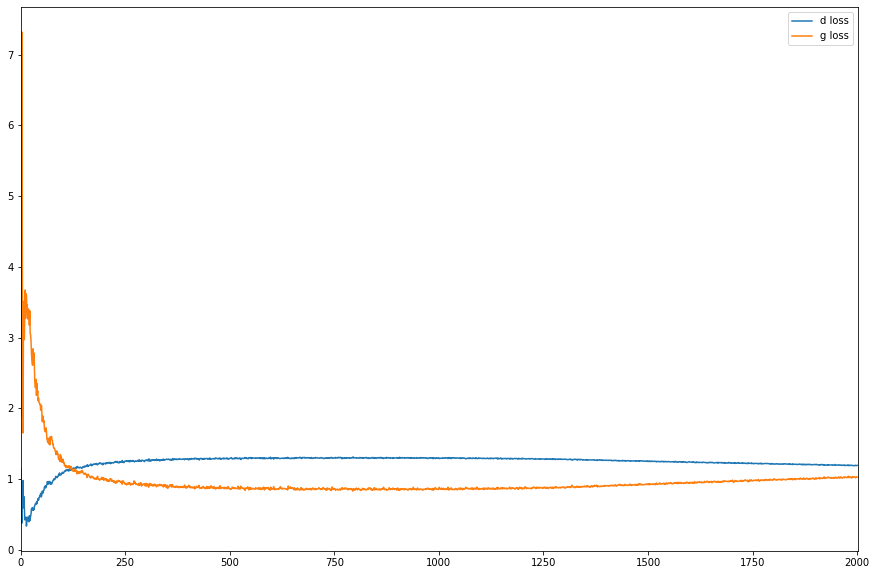

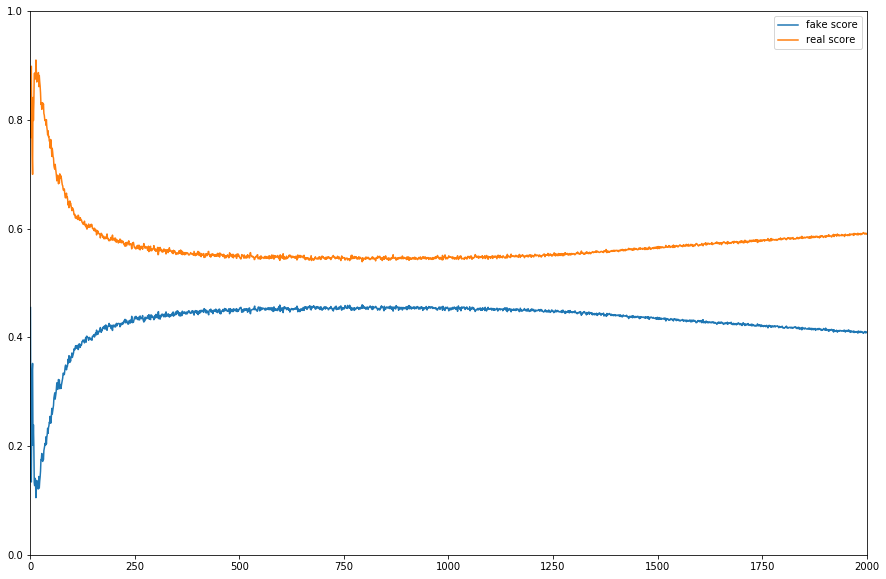

In [36]:
plt.figure(figsize=(15,10))
plt.xlim(0, num_epochs + 1)
plt.plot(range(1, num_epochs + 1), d_losses, label='d loss')
plt.plot(range(1, num_epochs + 1), g_losses, label='g loss')    
plt.legend()
plt.show()    

plt.figure(figsize=(15,10))
plt.xlim(0, num_epochs + 1)
plt.ylim(0, 1)
plt.plot(range(1, num_epochs + 1), fake_scores, label='fake score')
plt.plot(range(1, num_epochs + 1), real_scores, label='real score')    
plt.legend()

plt.show()

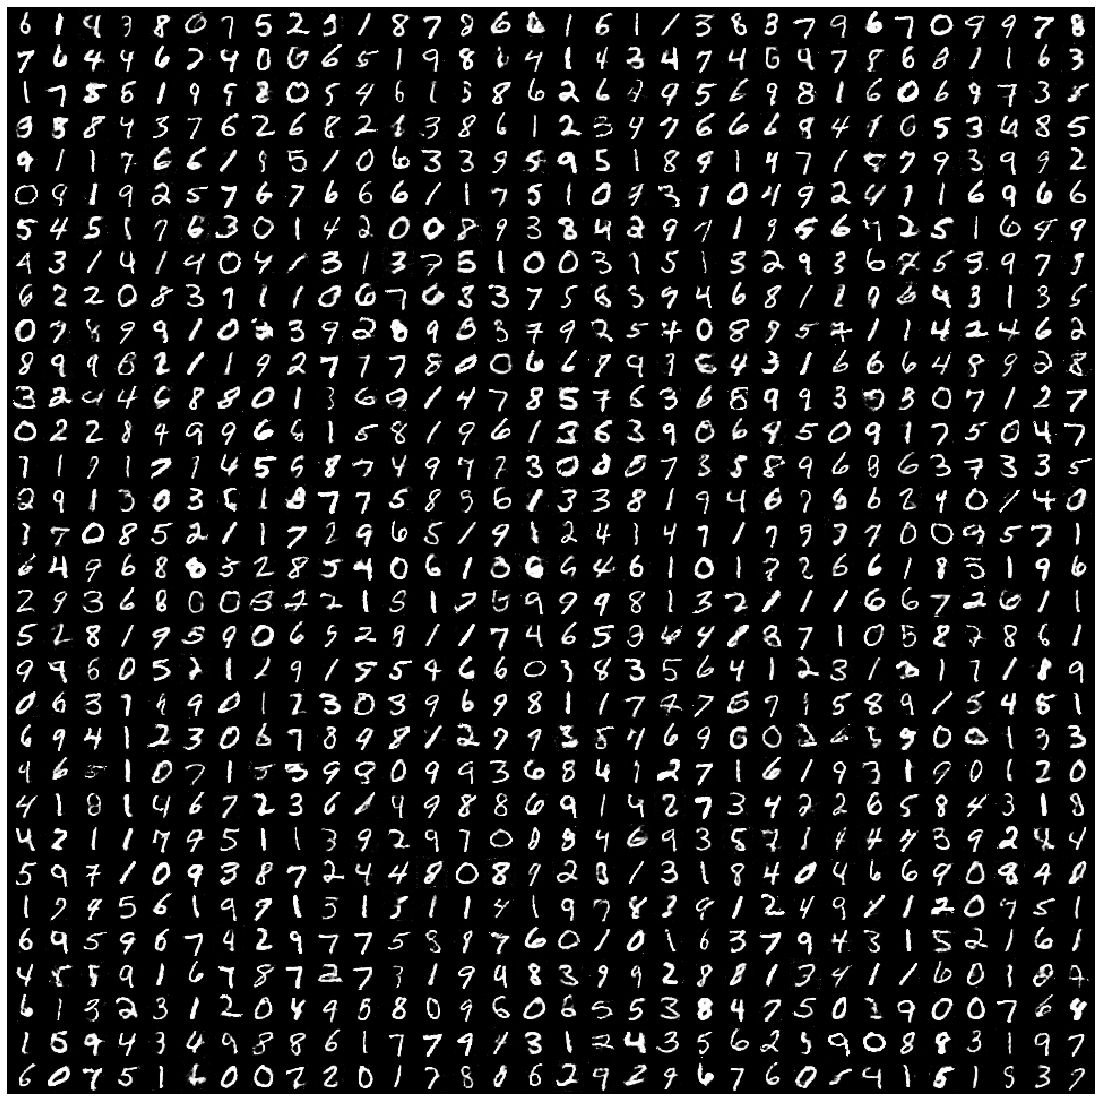

In [31]:
bsz = 1024

with torch.no_grad():
    test_z = torch.randn(bsz, z_dim).to(device)
    generated = denorm(G(test_z).cpu())
        
    plt.figure(figsize=(20,20))
    show_batch(generated.view(bsz,1,28,28),nrow=32)
    
#    save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_' + '.png')